In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import torch

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

from scipy.linalg import sqrtm
from statsmodels.stats.correlation_tools import cov_nearest
from torchdiffeq import odeint

from external_drift import (ScenarioParams, SignalDimension, 
                            apply_learnt_external_drift_to_sim, generate_training_set,
                            train_univariate_neural_ode_external_drift,
                            train_neural_ode_external_drift, train_multivariate_neural_ode_external_drift)
from ml import KramersMoyal, load_kernels_dict
from neural_ode import NeuralODEfunc, RunningAverageMeter
from plot import ImperialColors, plot_simulation
from plot.external_drift import plot_training_evaluation
from potenciala import BucketMethod, VectorTimeSeries
from stochastic import (EulerMaruyama, SpatialNearestDriftMultivariate, ConstantDiffusionMultivariate)

In [3]:
df_raw = pd.read_csv("day_ahead_market_20211005.csv")
df_raw["spain"] = df_raw["spain"].round(decimals=2)

In [4]:
df = df_raw.query("year >= 2004 & year <= 2020")

### Load VectorTimeSeries and drift and diffusion coefficients

In [5]:
s_kde = VectorTimeSeries(df=df, signal_name="spain", bucket_method=BucketMethod.NoBucket)

d_1_dict = load_kernels_dict(path="data/kde/d_1/", pattern="d_1_(.*)_1000_1000", dim_num=1)
expected_drift_kde_df = KramersMoyal.obtain_first_coefficient_vector(kernels_dict=d_1_dict)

d_2_diag_dict = load_kernels_dict(path="data/kde/d_2_diag/", pattern="d_2_diag_(.*)_1000_1000", dim_num=1)
d_2_non_diag_dict = load_kernels_dict(
    path="data/kde/d_2_non_diag/", pattern="d_2_non_diag_(.*)_100_100", dim_num=2
)
second_km_kde_matrix = KramersMoyal.obtain_second_coefficient_matrix(diag_kernels_dict=d_2_diag_dict, 
                                                                     non_diag_kernels_dict=d_2_non_diag_dict)

drift_kde = SpatialNearestDriftMultivariate(df=expected_drift_kde_df)

sqrt_diff_matrix_kde = sqrtm(cov_nearest(cov=2*second_km_kde_matrix, threshold=1e-14))
cte_diffusion_kde = ConstantDiffusionMultivariate(df=pd.DataFrame(sqrt_diff_matrix_kde))

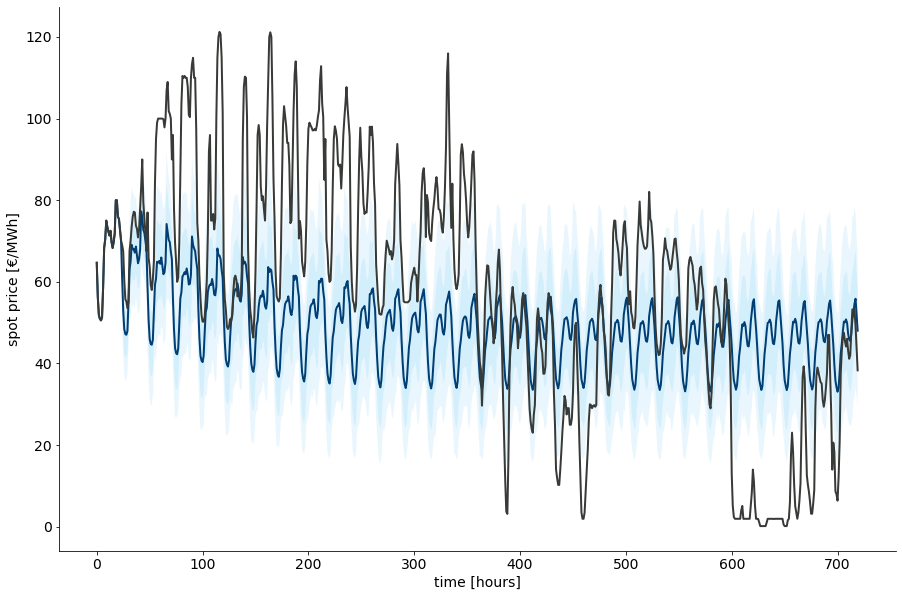

In [6]:
scenario_params = ScenarioParams(sim_periods=30, 
                                 n_sim=1_000, 
                                 delta_t=1, 
                                 seed=1_024, 
                                 batch_size=30, 
                                 obs_dim=24,
                                 epochs=2_000,
                                 lr=1e-3)

x_df = df_raw[df_raw["date"] >= "2021-01-05"].iloc[:24*scenario_params.sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=scenario_params.n_sim, 
                   periods=scenario_params.sim_periods, 
                   delta_t=scenario_params.delta_t, 
                   nu=0, 
                   drift=drift_kde, 
                   diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=scenario_params.random_seed)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

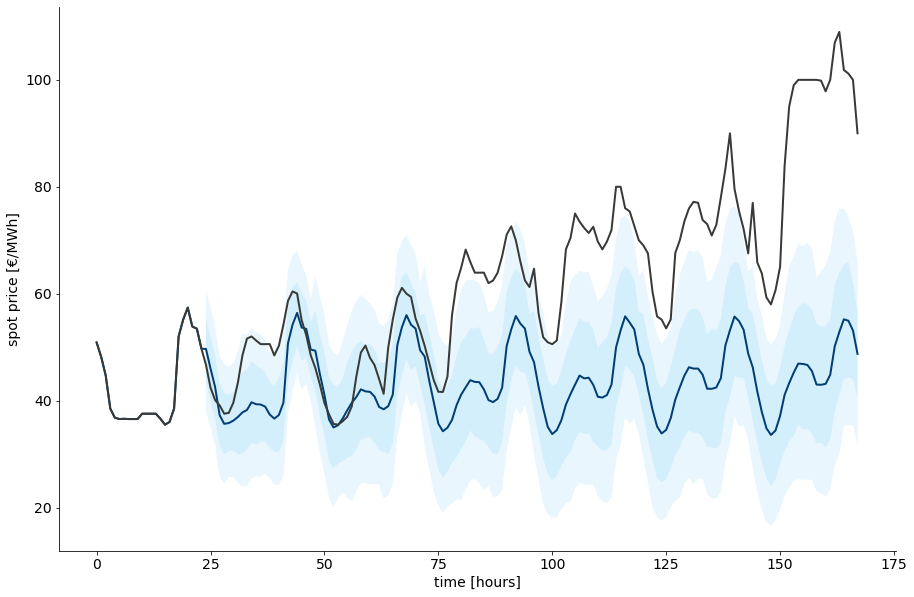

In [7]:
scenario_params = ScenarioParams(sim_periods=7, 
                                 n_sim=1_000, 
                                 delta_t=1, 
                                 seed=1_024, 
                                 batch_size=30, 
                                 obs_dim=24,
                                 epochs=2_000,
                                 lr=1e-3)

x_df = df_raw[df_raw["date"] >= "2021-01-01"].iloc[:24*scenario_params.sim_periods]
x_df_kde = x_df.copy(deep=True)
x_0 = x_df["spain"].iloc[:24].values

em = EulerMaruyama(num_sim=scenario_params.n_sim, 
                   periods=scenario_params.sim_periods, 
                   delta_t=scenario_params.delta_t, 
                   nu=0, 
                   drift=drift_kde, 
                   diffusion=cte_diffusion_kde)

sim_df = em.simulate(x0=x_0, random_seed=scenario_params.random_seed)

sim_dict = {"sim_df": sim_df, "actual_df": x_df_kde}
plot_simulation(sim_dict=sim_dict)

### Compute difference between simulation and external drift to generate training set

In [8]:
hour_ts_diff_df = generate_training_set(sim_df=sim_df, 
                                        actual_series=x_df_kde.reset_index()["spain"], 
                                        params=scenario_params)

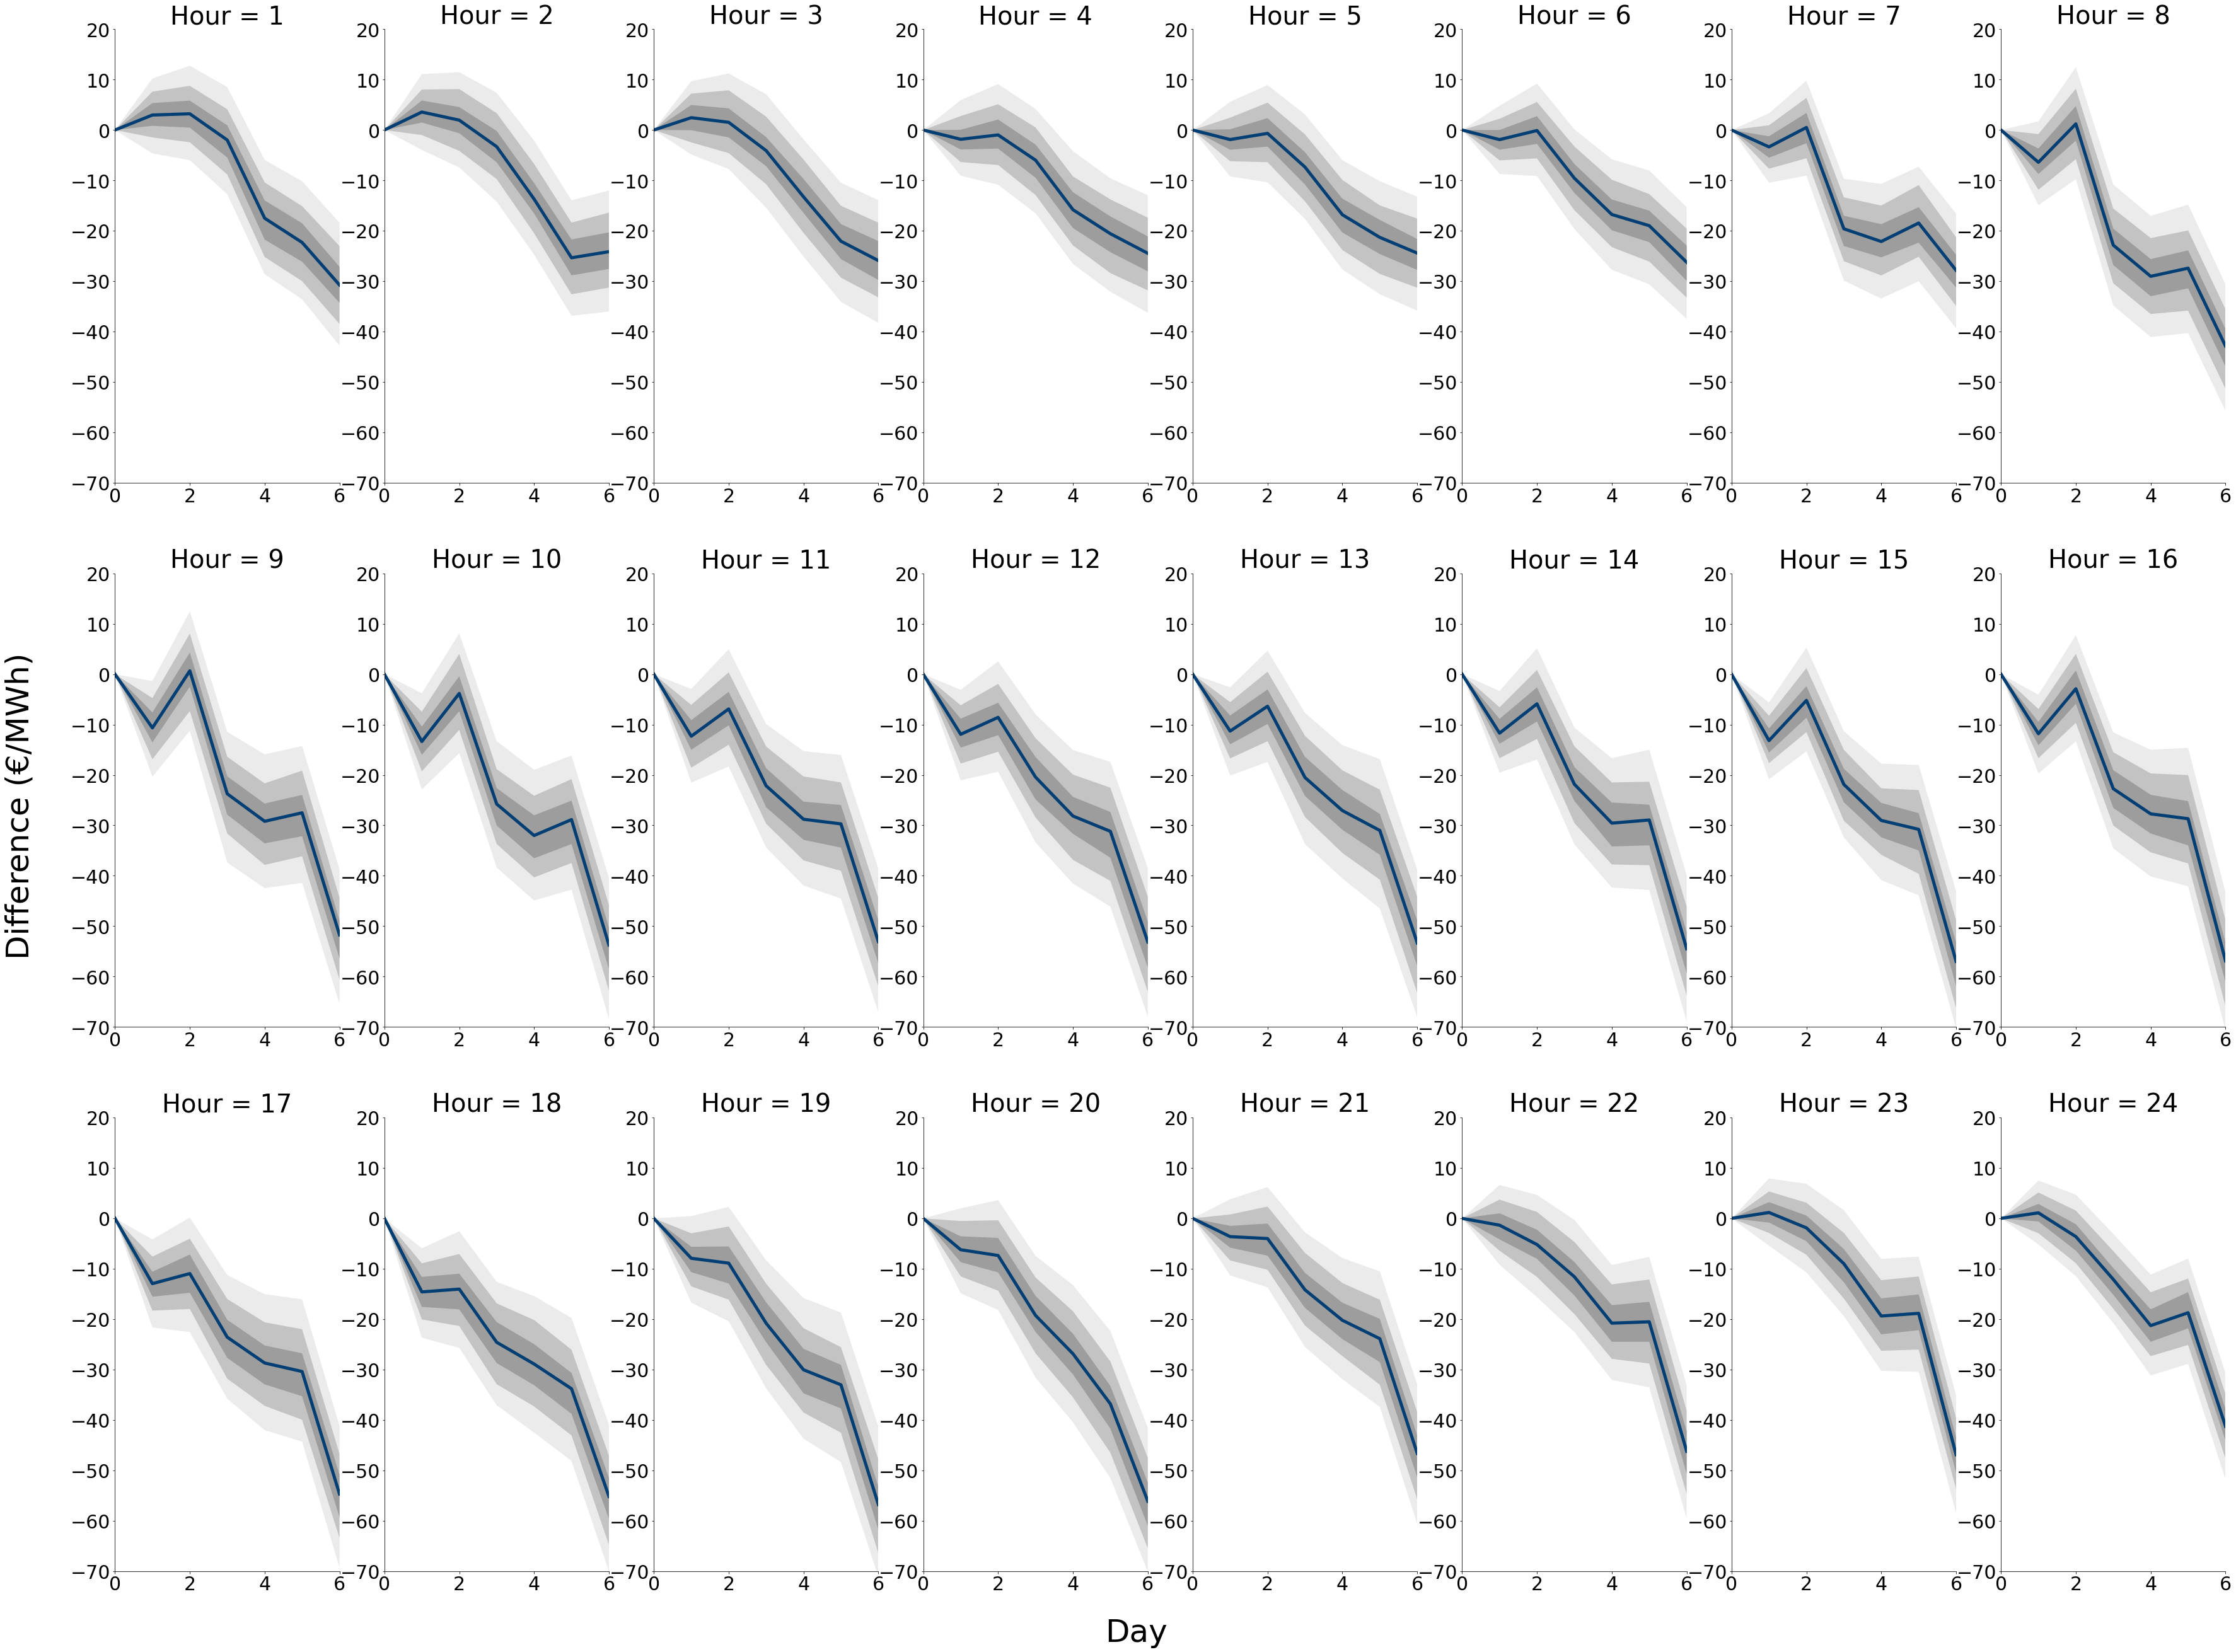

In [9]:
fig, axis = plt.subplots(3, 8, figsize=(60, 45))
percentiles_alpha = [0.2, 0.5, 1]
quantile = [0.2, 0.3, 0.4, 0.6, 0.7, 0.8]

for i, ax_list in enumerate(axis):
    for j, ax in enumerate(ax_list):
        h = 1 + i*8+j
        hour_ts_diff_df.loc[h].mean(axis=1).plot(ax=ax, lw=5, color=ImperialColors.blue.value)
        
        percentile_df = hour_ts_diff_df.loc[h].quantile(q=quantile, axis=1)
        for k, alpha_value in enumerate(percentiles_alpha):            
            ax.fill_between(
                percentile_df.columns, 
                percentile_df.loc[quantile[k]], 
                percentile_df.loc[quantile[-k-1]],
                facecolor=ImperialColors.cool_grey.value, 
                alpha=alpha_value
            )
        ax.set_xlabel("")
        ax.set_title(f"Hour = {h}", fontsize=40)
        ax.set_xlim(0, scenario_params.sim_periods-1)
        ax.set_ylim(-70, 20)
        ax.tick_params(axis="both", labelsize=30)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
fig.text(0.5, 0.095, "Day", ha="center", va="center", fontdict={"size": 50})
fig.text(0.09, 0.5, "Difference (€/MWh)", ha="center", va="center", fontdict={"size": 50}, rotation=90)
plt.show()

### Train simple neural ODE to learn external drift

Training time step 1 - Iteration: 0000 | Total loss 5.873914 | Time: 0.00 mins


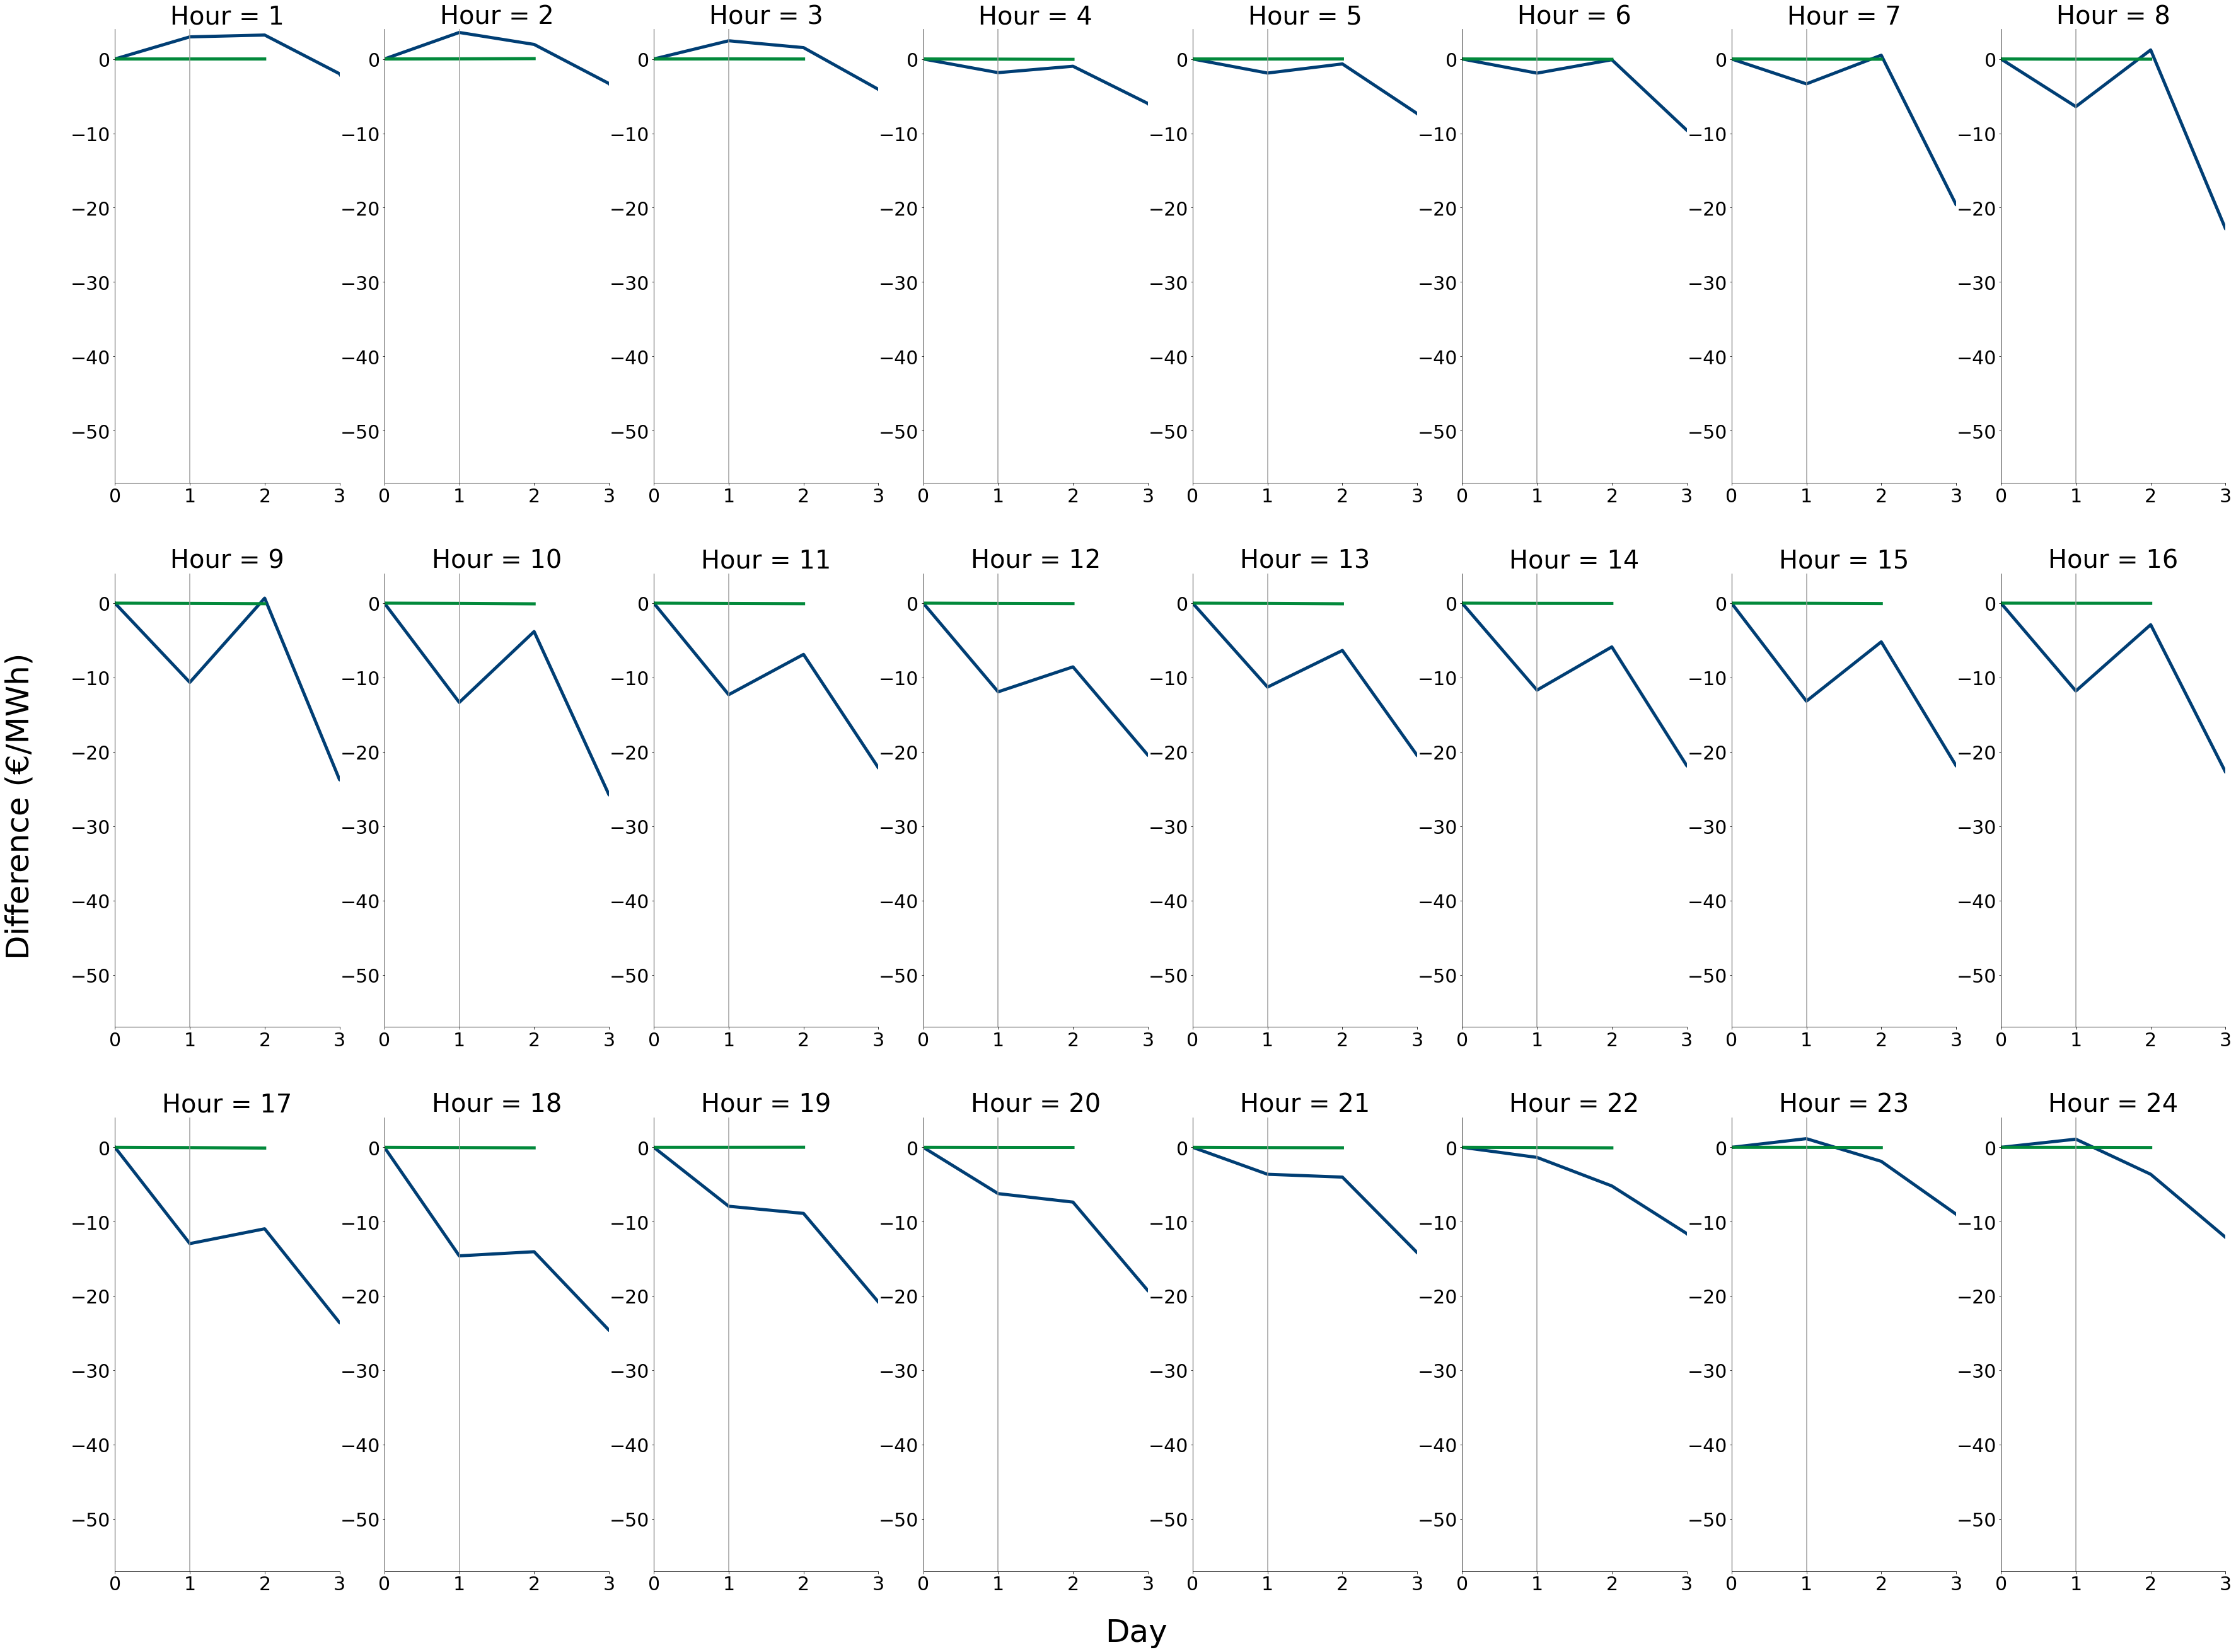

Mean absolute value error for test: 4.40


Training time step 1 - Iteration: 0250 | Total loss 3.776026 | Time: 0.29 mins
Training time step 1 - Iteration: 0500 | Total loss 3.782530 | Time: 0.55 mins
Training time step 1 - Iteration: 0750 | Total loss 3.761654 | Time: 0.82 mins
Training time step 1 - Iteration: 1000 | Total loss 3.784628 | Time: 1.08 mins


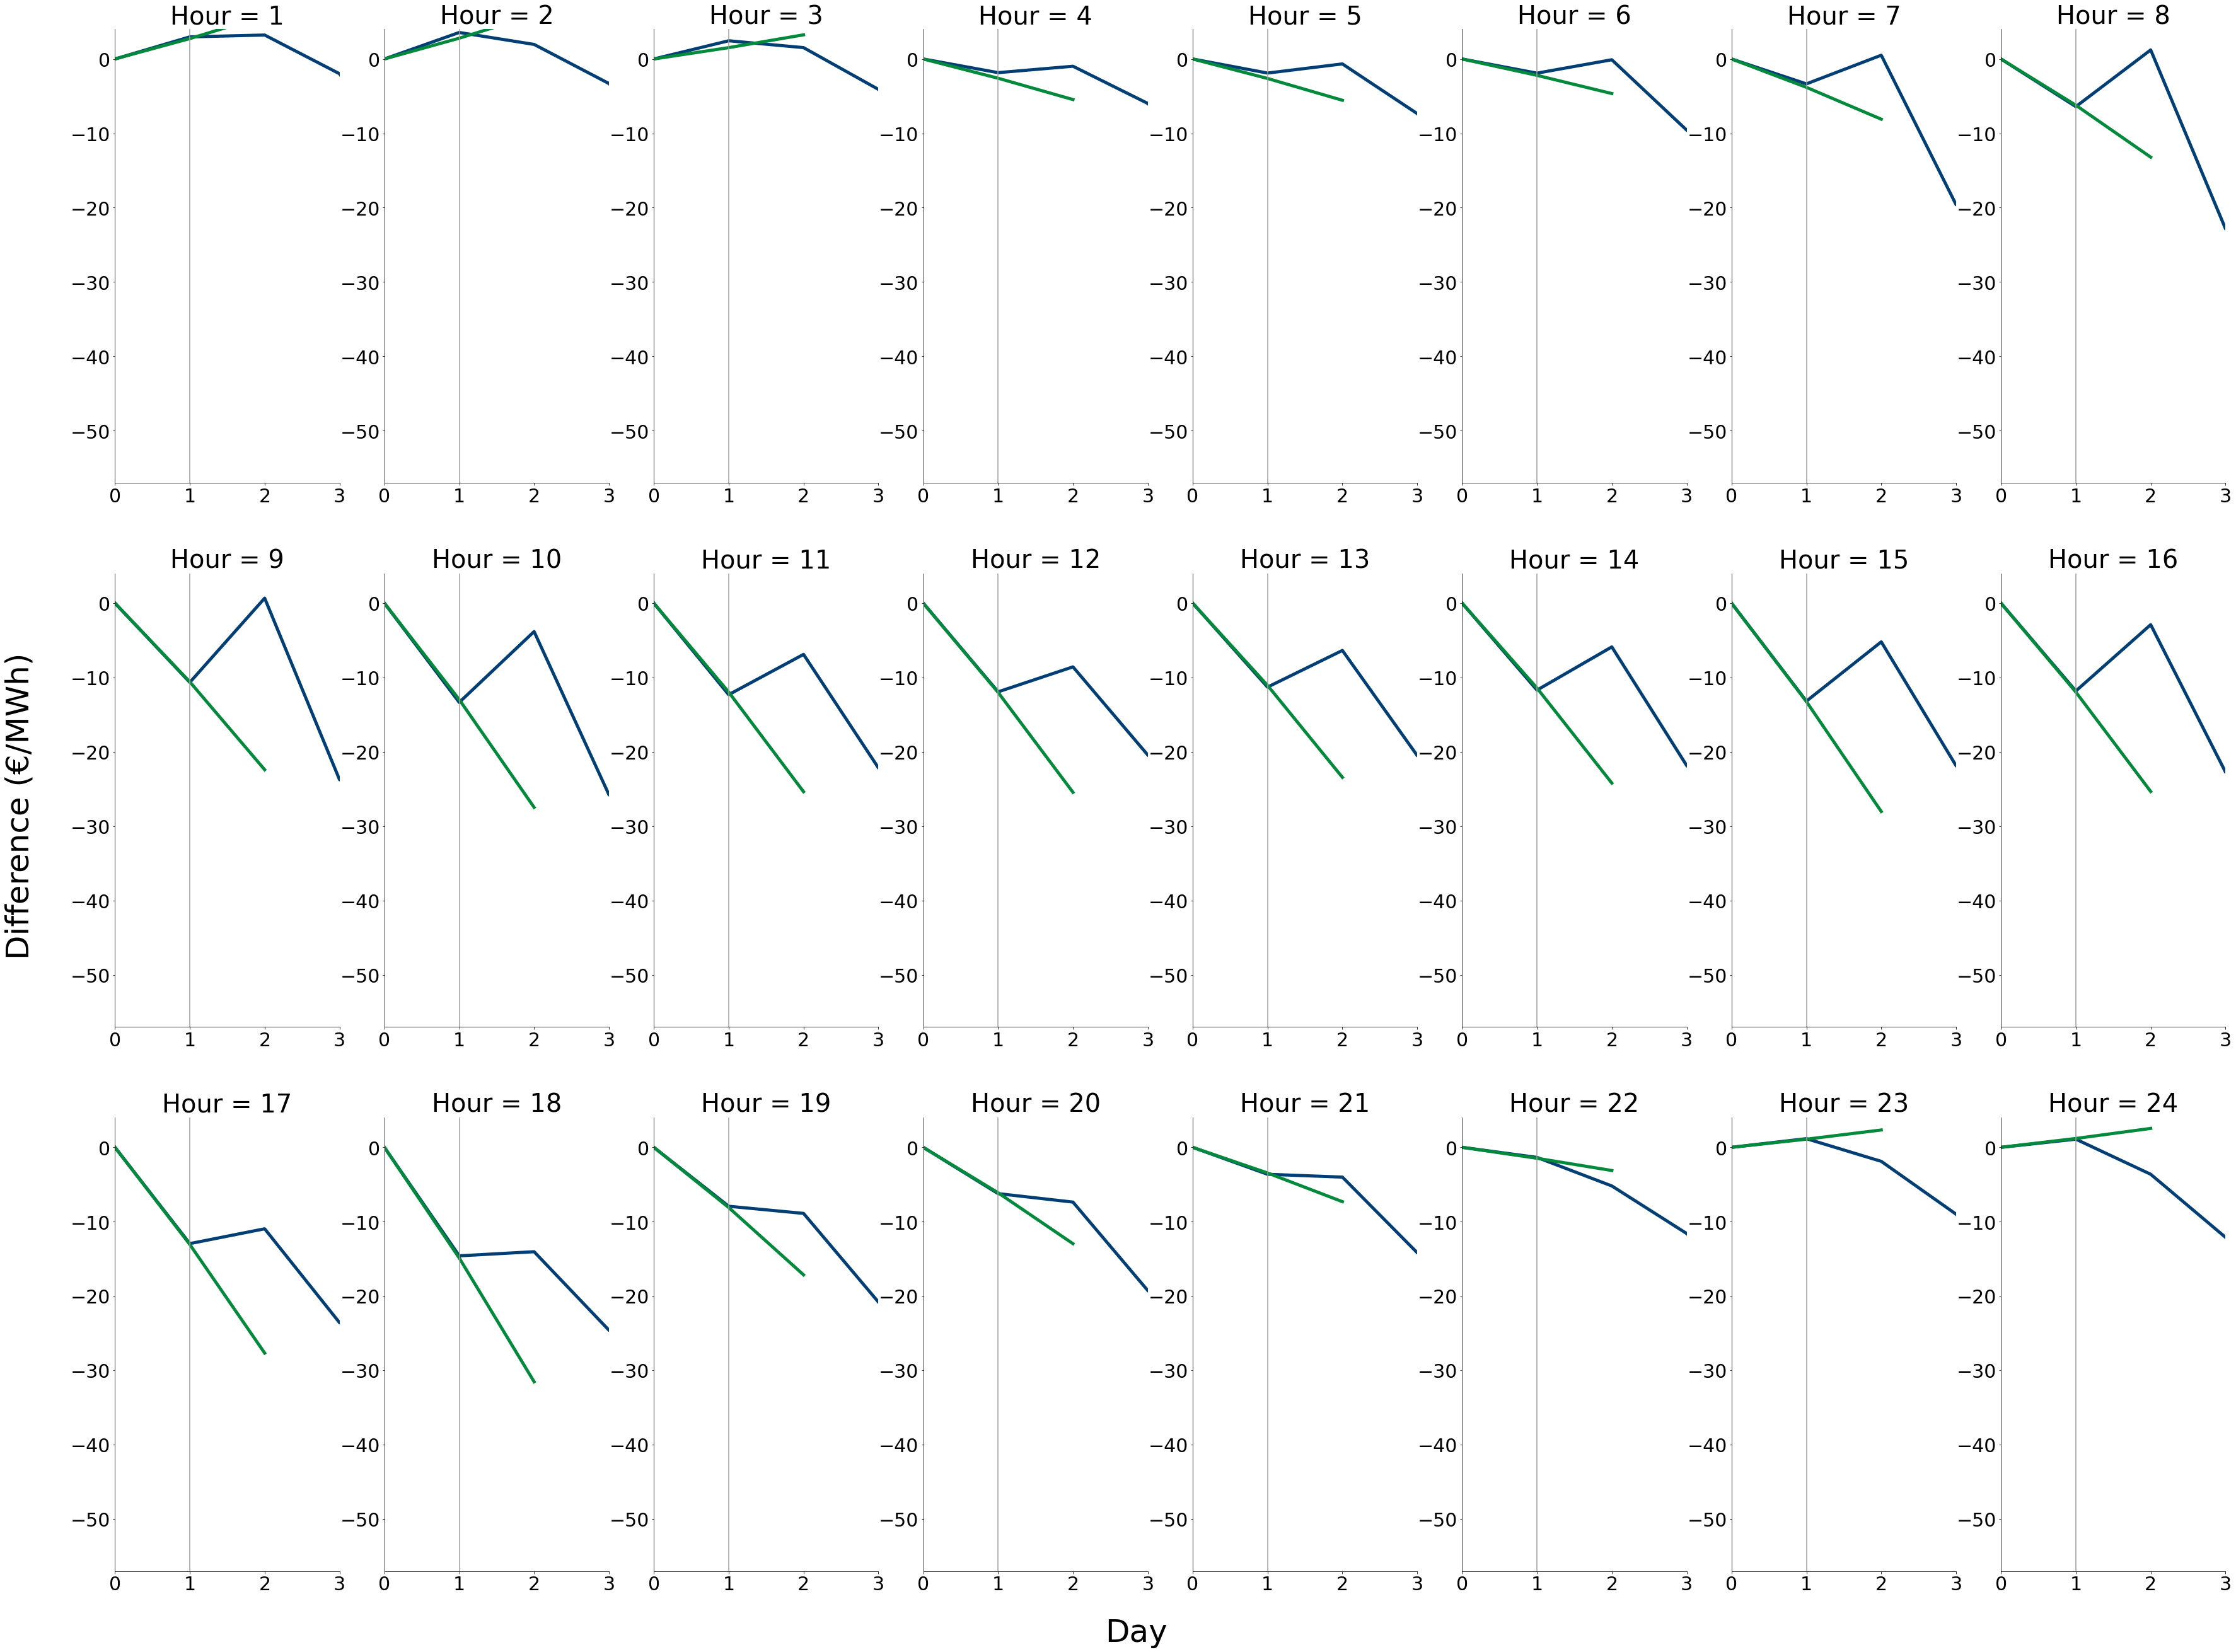

Mean absolute value error for test: 11.32


Training time step 1 - Iteration: 1250 | Total loss 3.819240 | Time: 1.38 mins
Training time step 1 - Iteration: 1500 | Total loss 3.775403 | Time: 1.63 mins
Training time step 1 - Iteration: 1750 | Total loss 3.784802 | Time: 1.89 mins
Training time step 1 - Iteration: 2000 | Total loss 3.783892 | Time: 2.16 mins


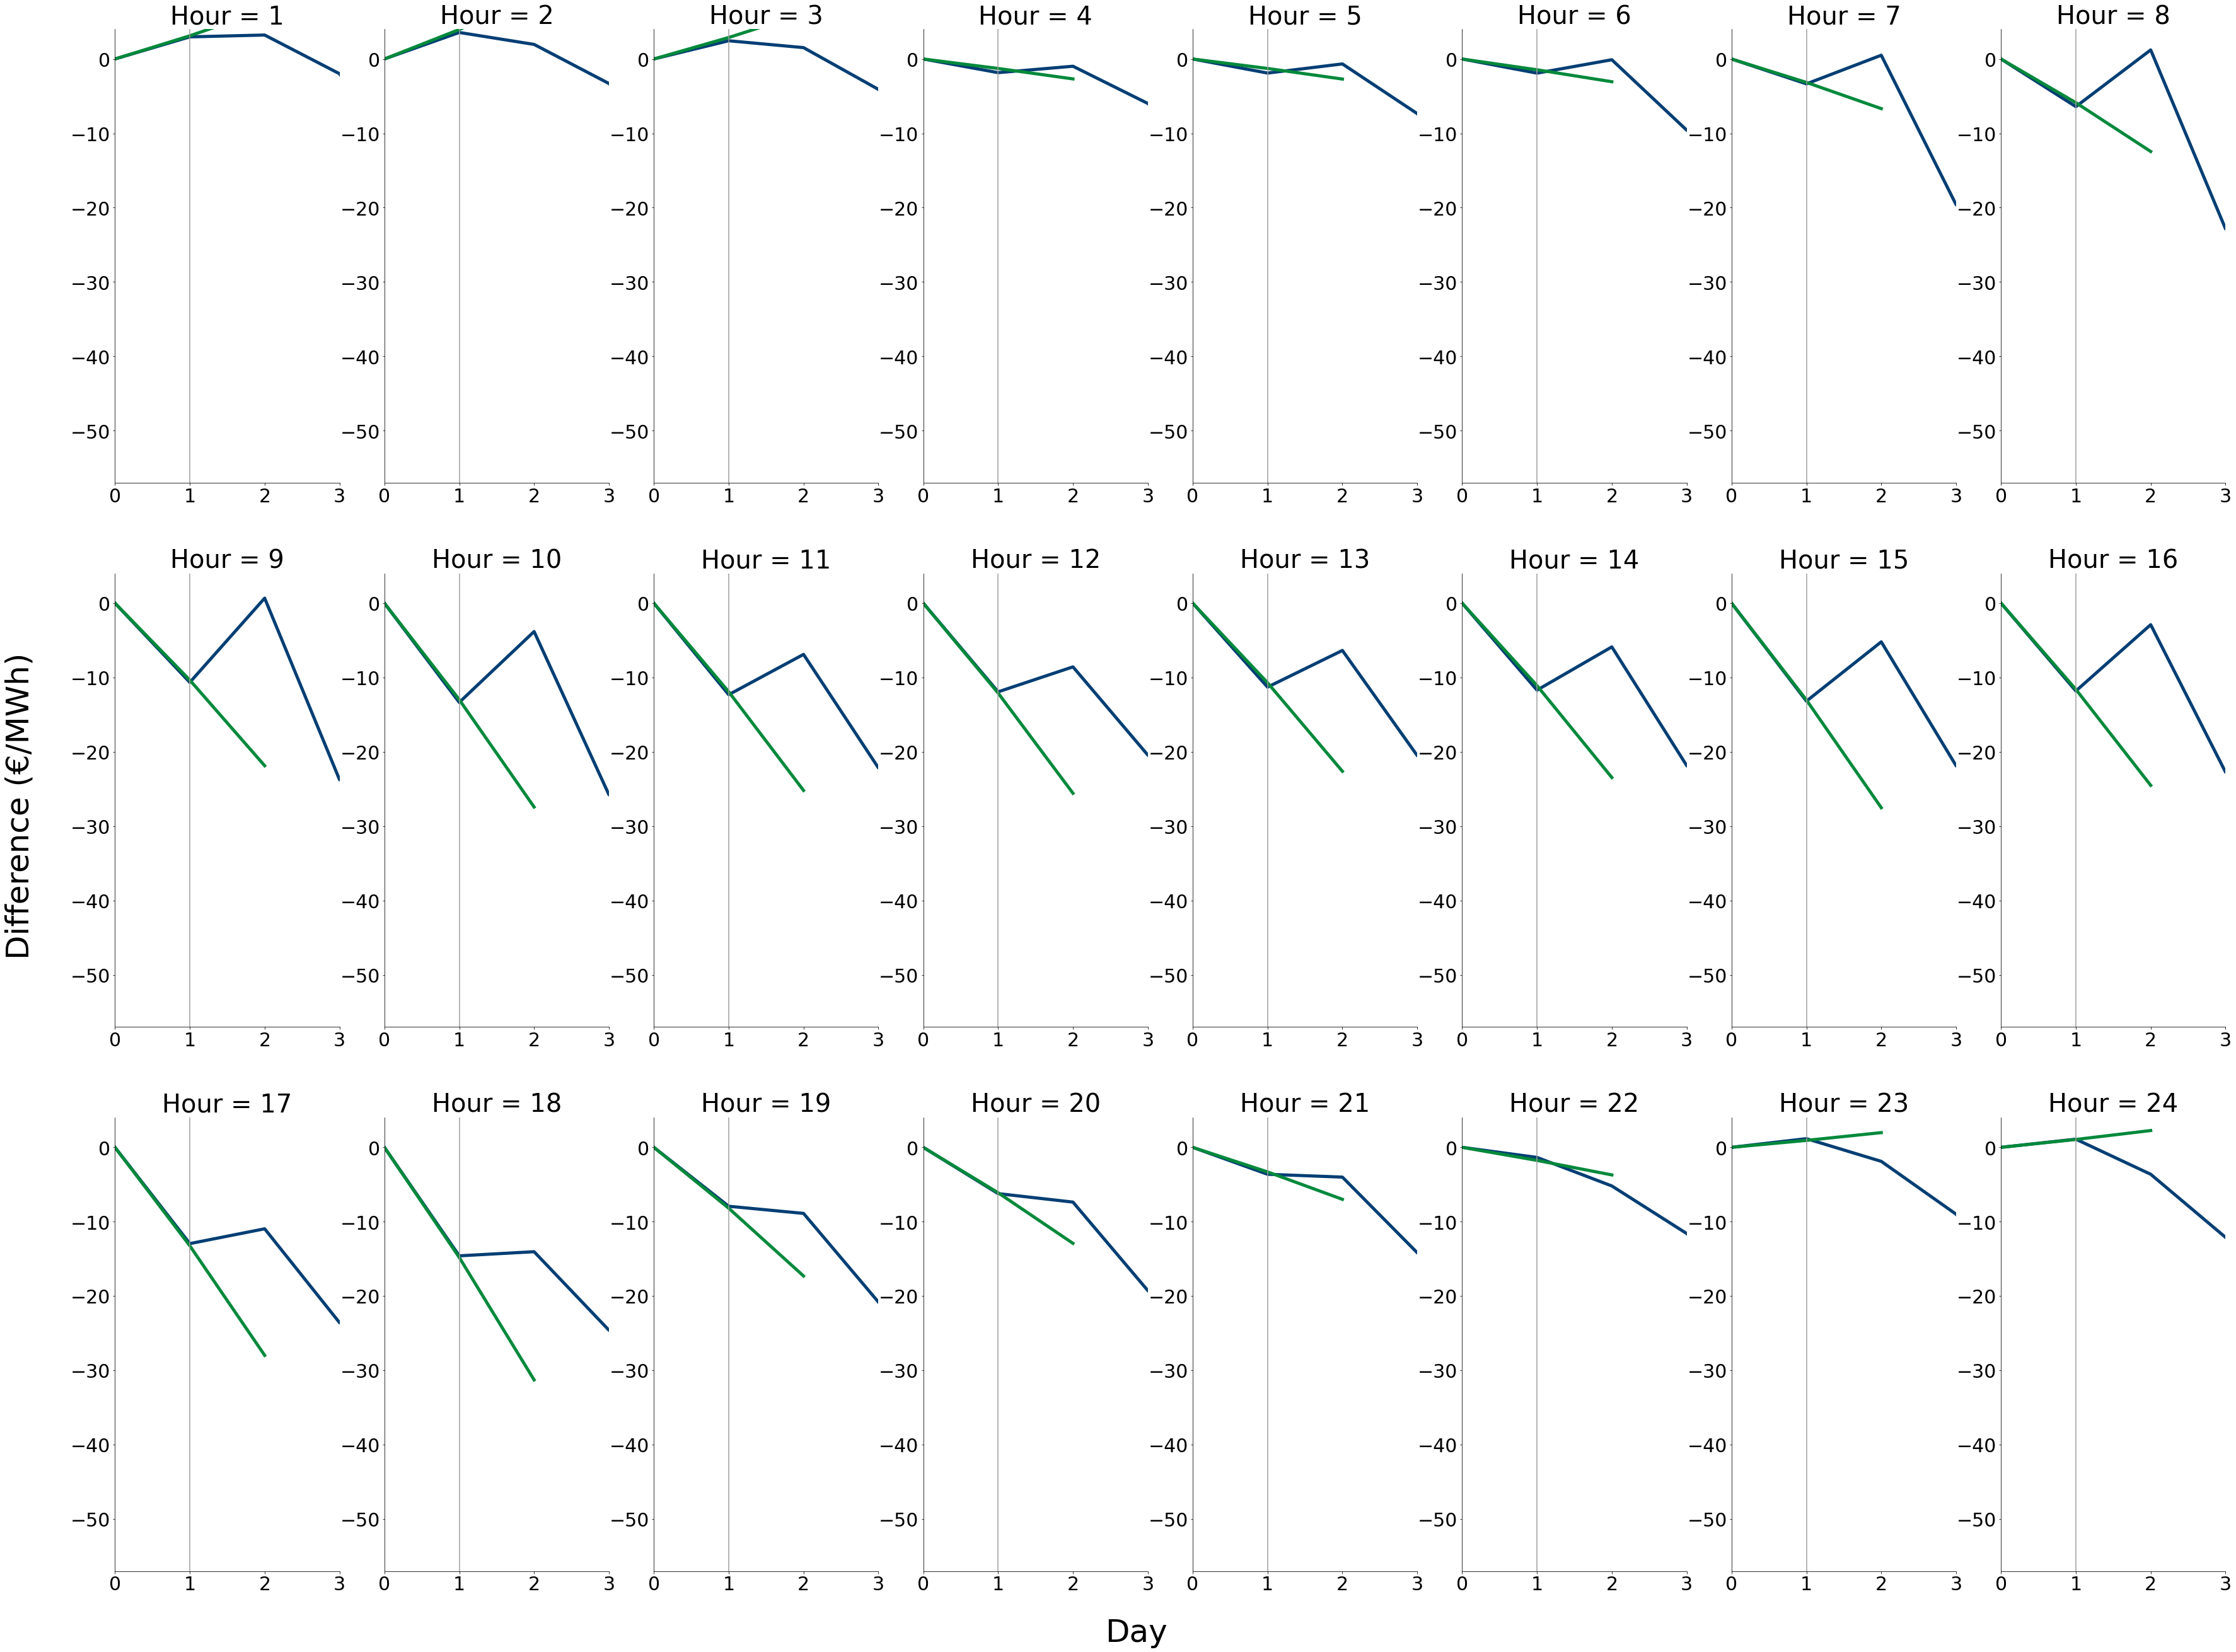

Mean absolute value error for test: 10.98




In [10]:
scenario_params.sim_periods = 3
pred_ext_drift_dict = train_multivariate_neural_ode_external_drift(params=scenario_params, 
                                                                   hidden_layer_neurons=96, 
                                                                   learning_rate=1e-3,
                                                                   train_df=hour_ts_diff_df)

Training time step 1 - Iteration: 0000 | Total loss 5.130296 | Time: 0.00 mins


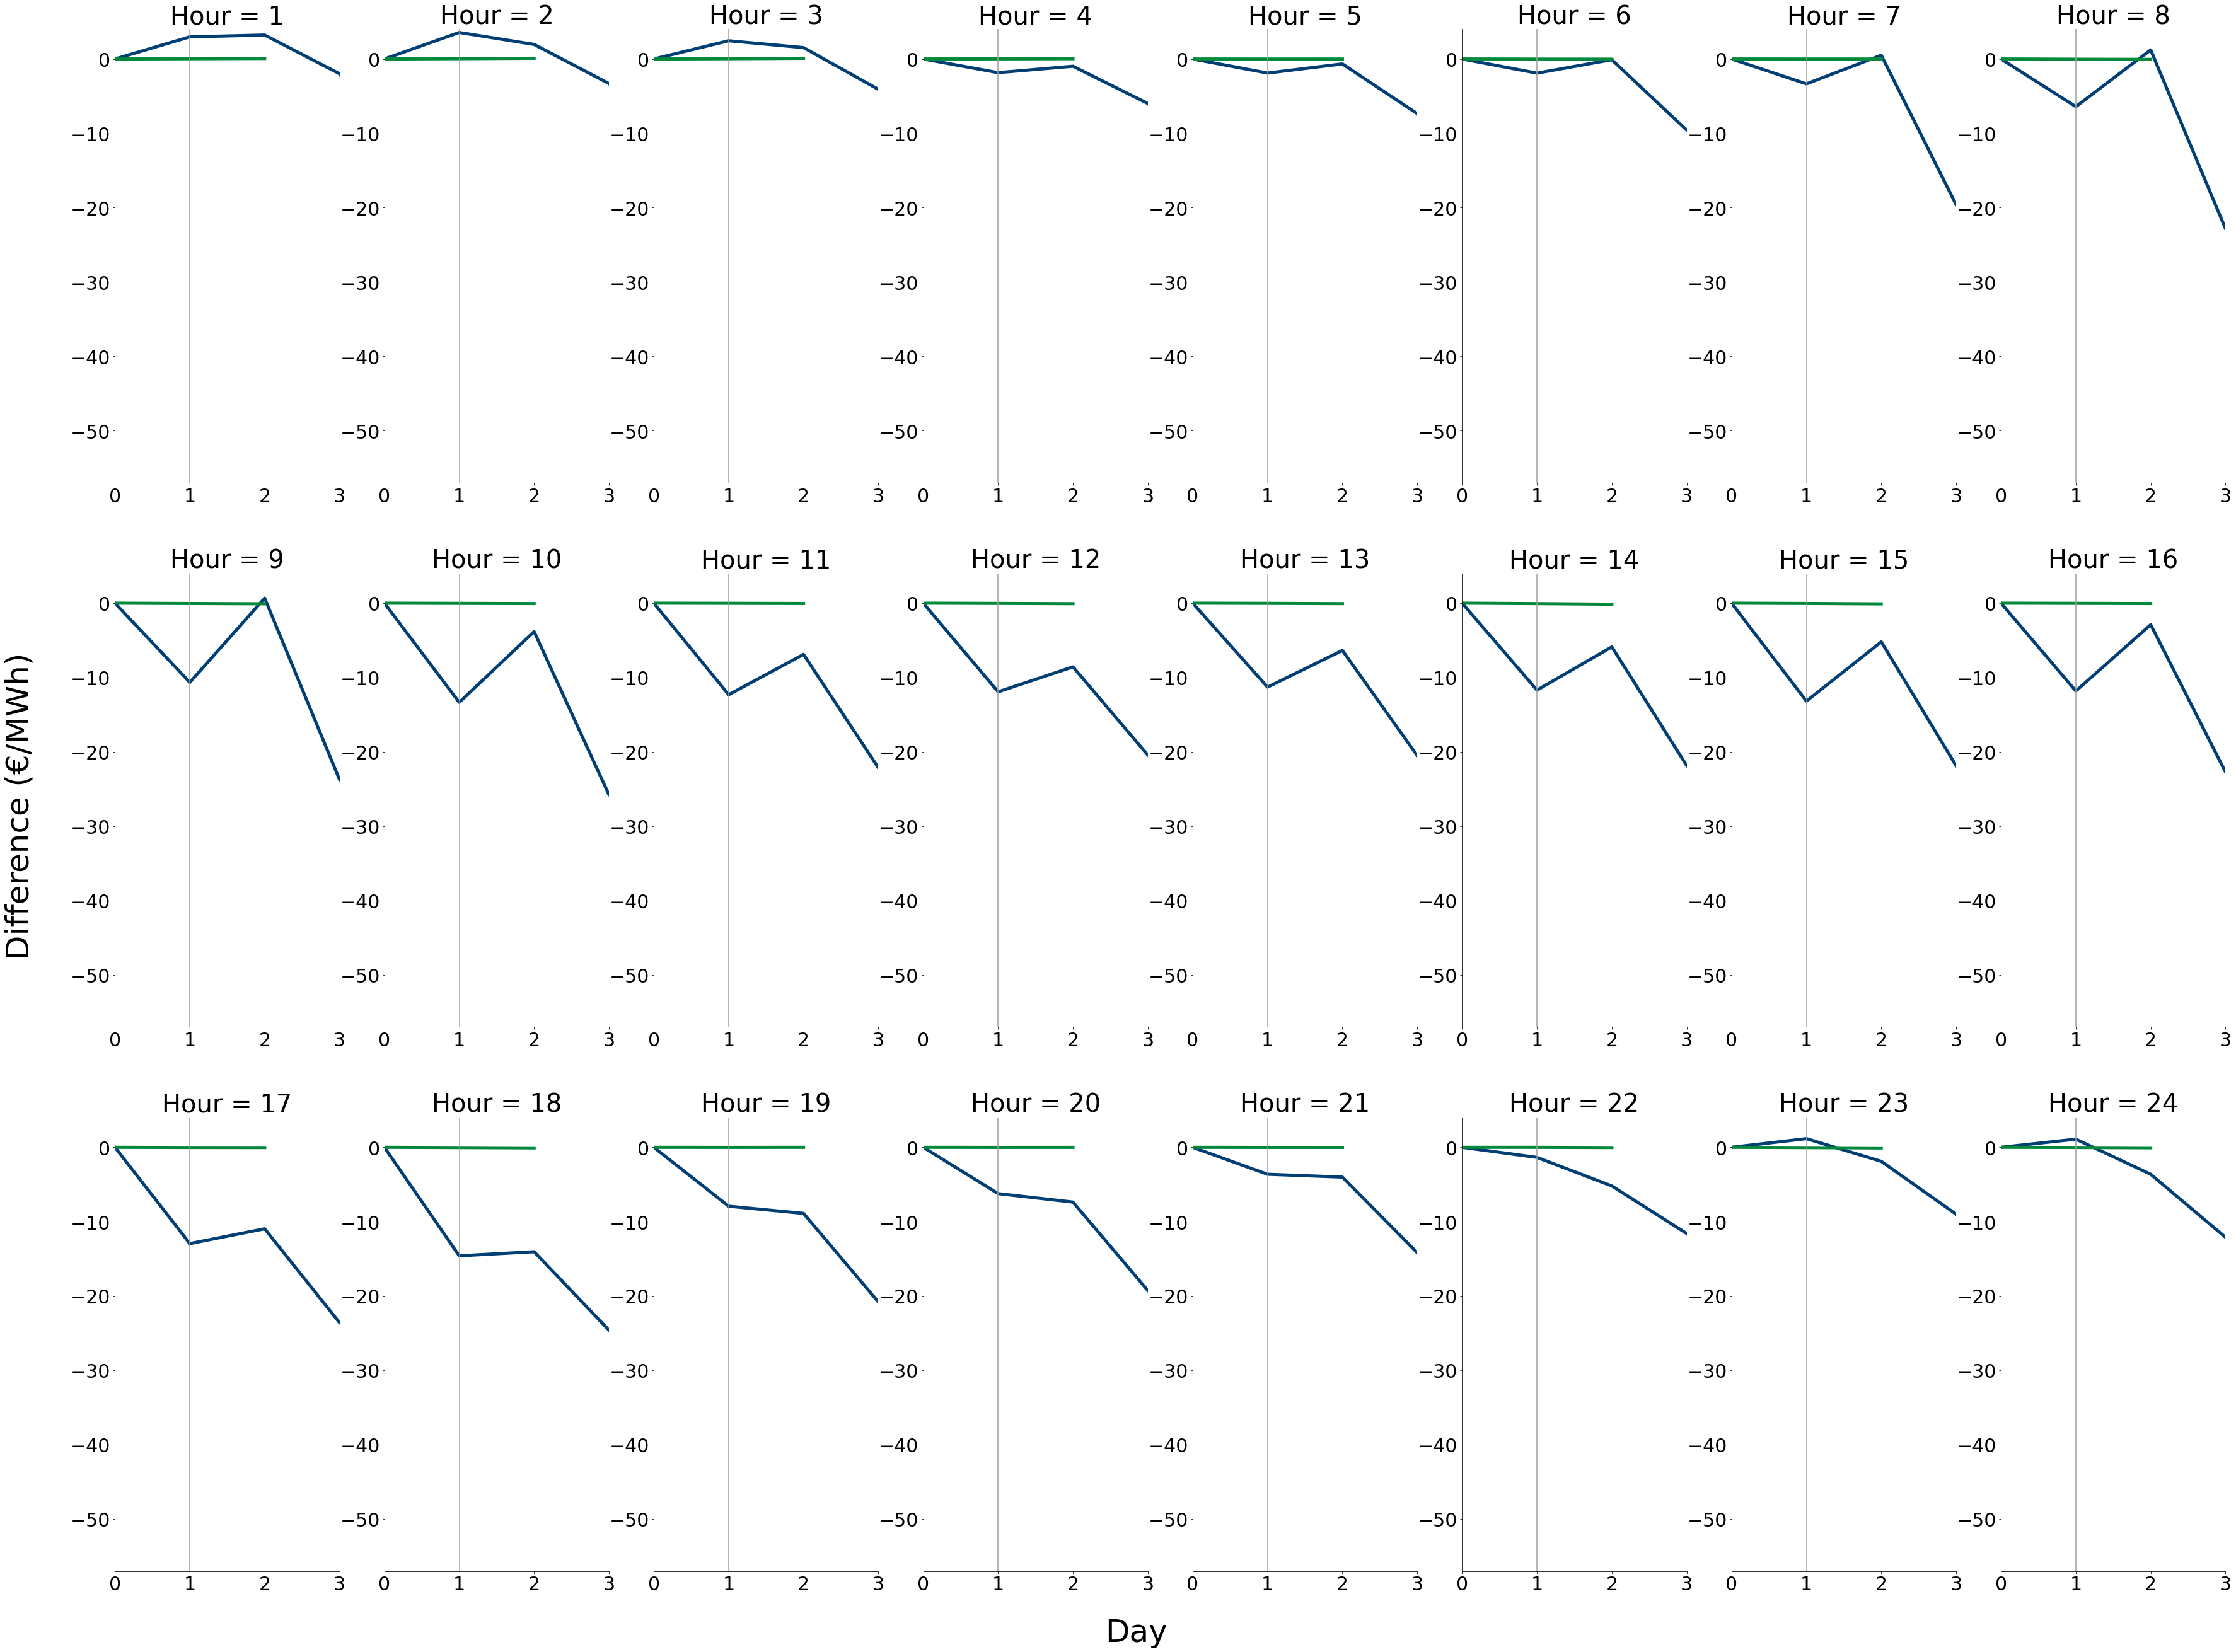

Mean absolute value error for test: 4.40


Training time step 1 - Iteration: 0250 | Total loss 3.853394 | Time: 0.32 mins
Training time step 1 - Iteration: 0500 | Total loss 3.821855 | Time: 0.63 mins
Training time step 1 - Iteration: 0750 | Total loss 3.754160 | Time: 0.93 mins
Training time step 1 - Iteration: 1000 | Total loss 3.831481 | Time: 1.21 mins


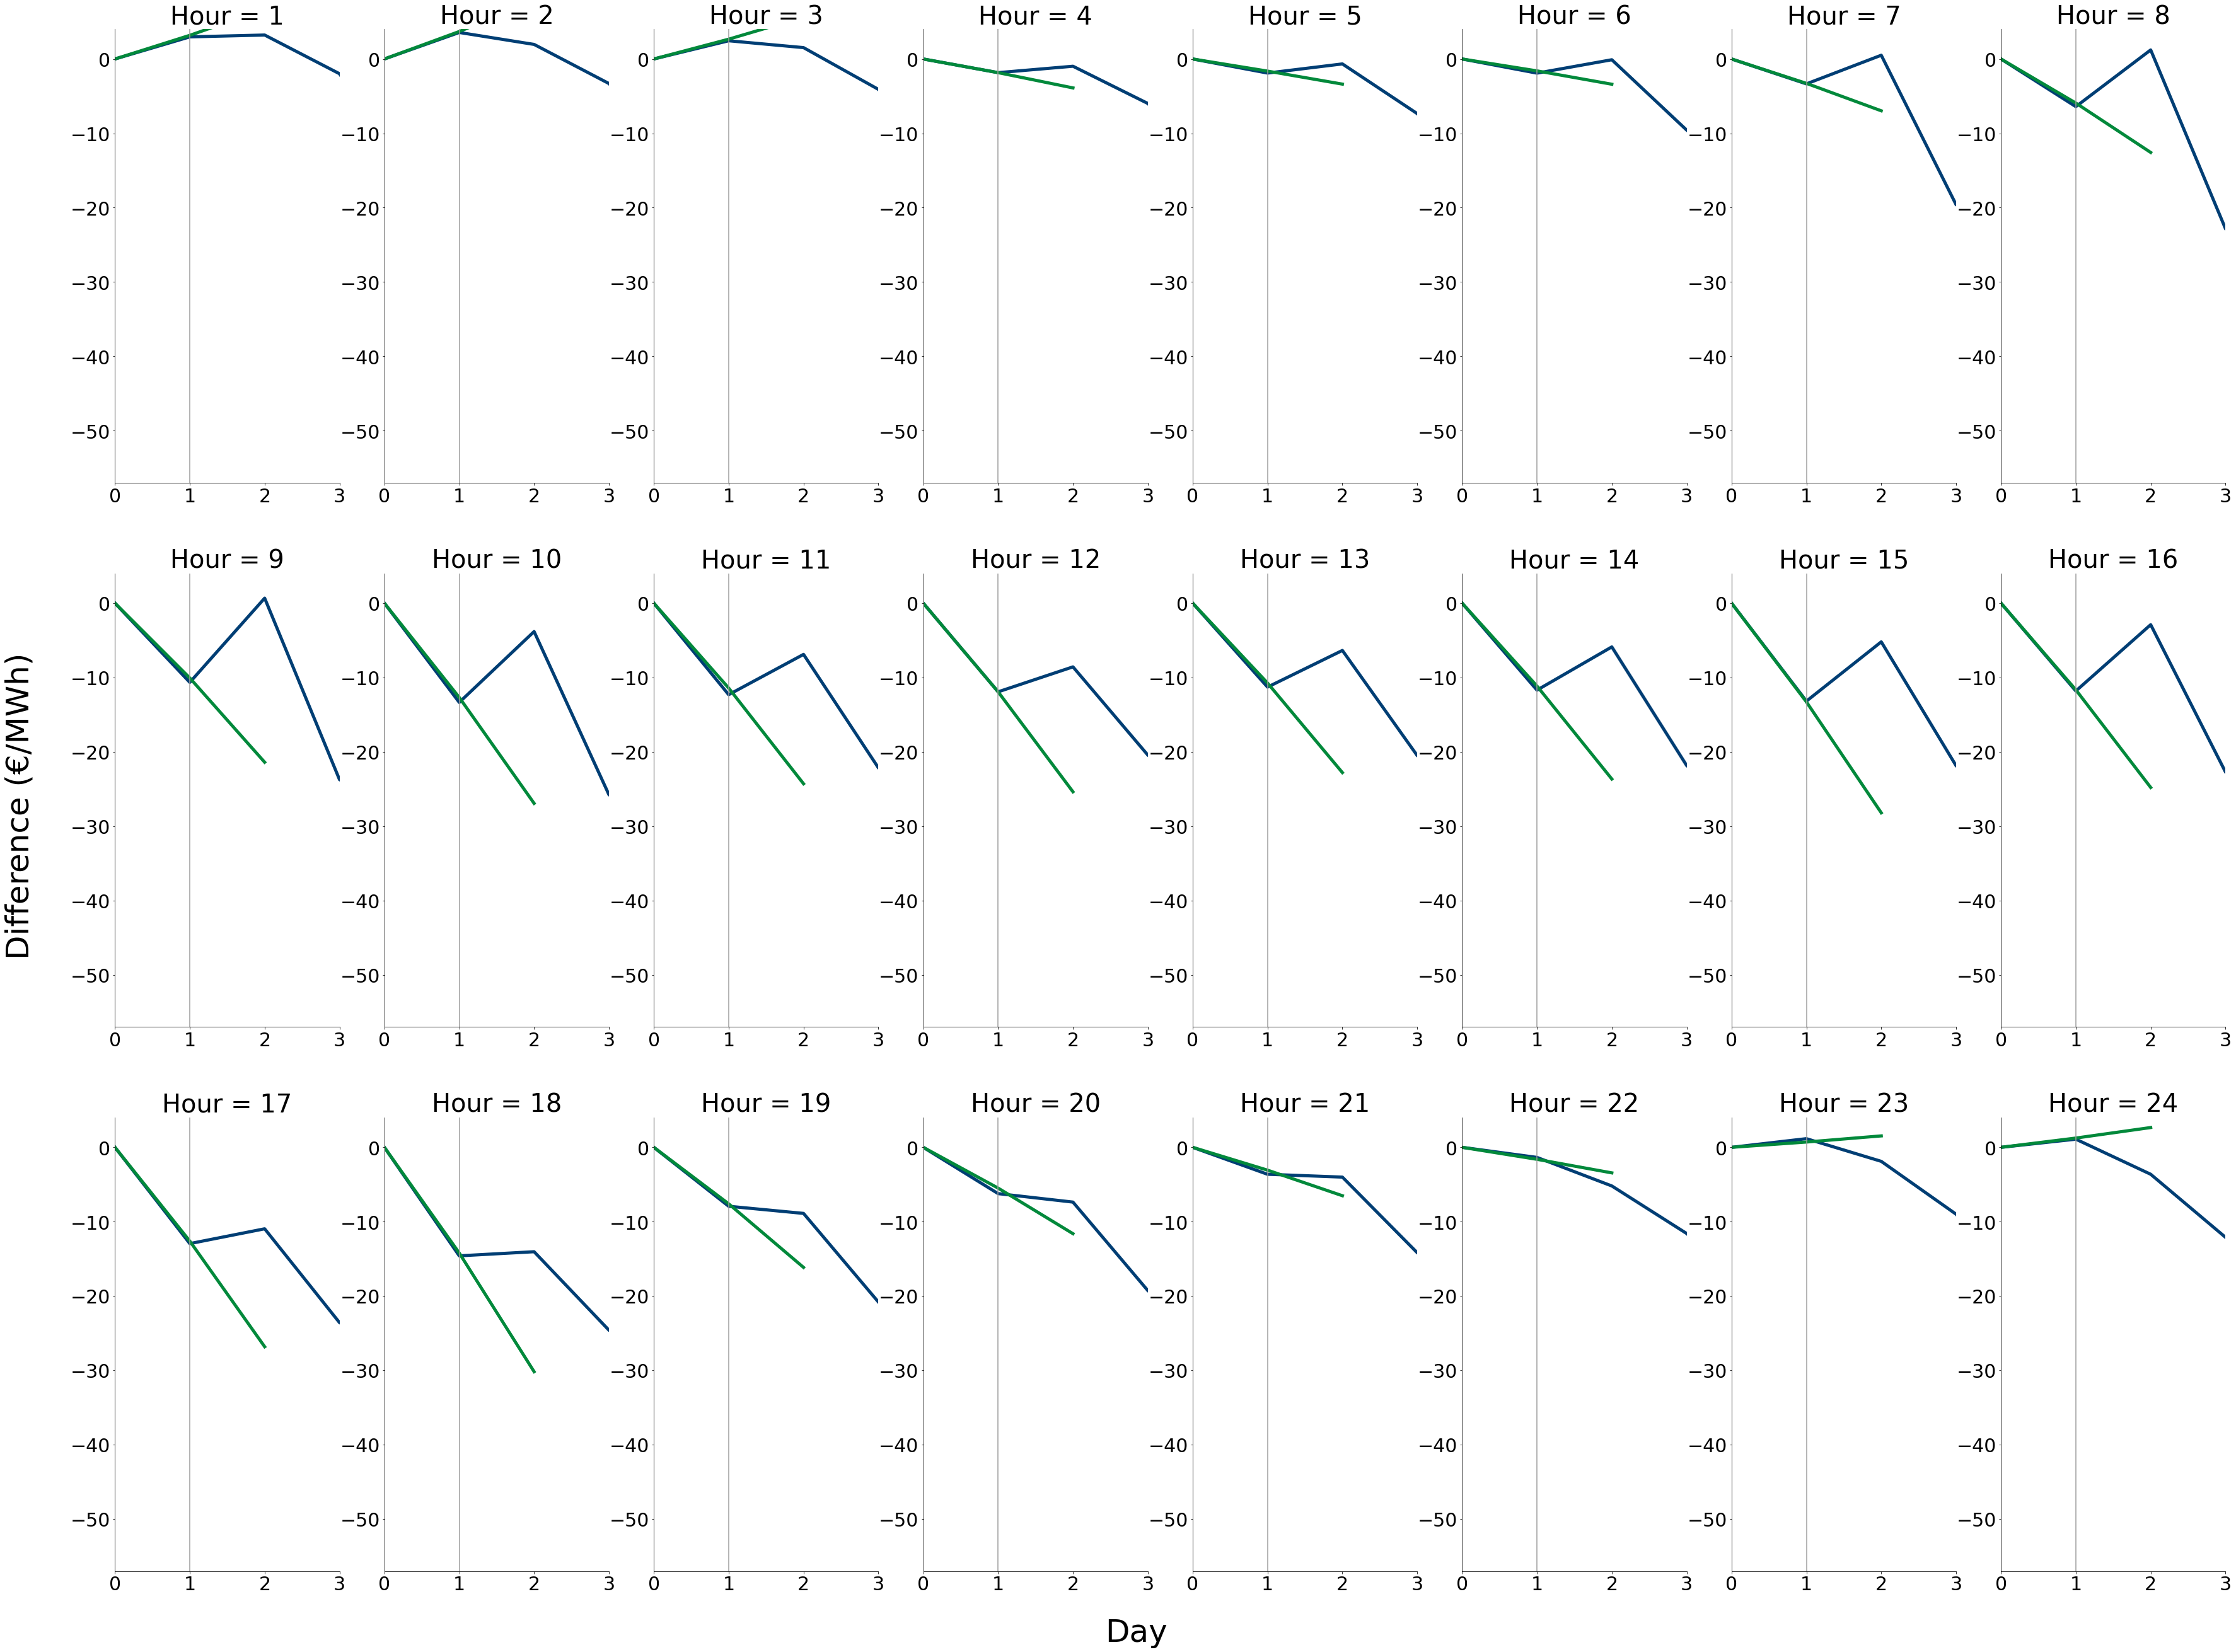

Mean absolute value error for test: 10.82


Training time step 1 - Iteration: 1250 | Total loss 3.832996 | Time: 1.50 mins
Training time step 1 - Iteration: 1500 | Total loss 3.801389 | Time: 1.76 mins
Training time step 1 - Iteration: 1750 | Total loss 3.807220 | Time: 2.02 mins
Training time step 1 - Iteration: 2000 | Total loss 3.785689 | Time: 2.28 mins


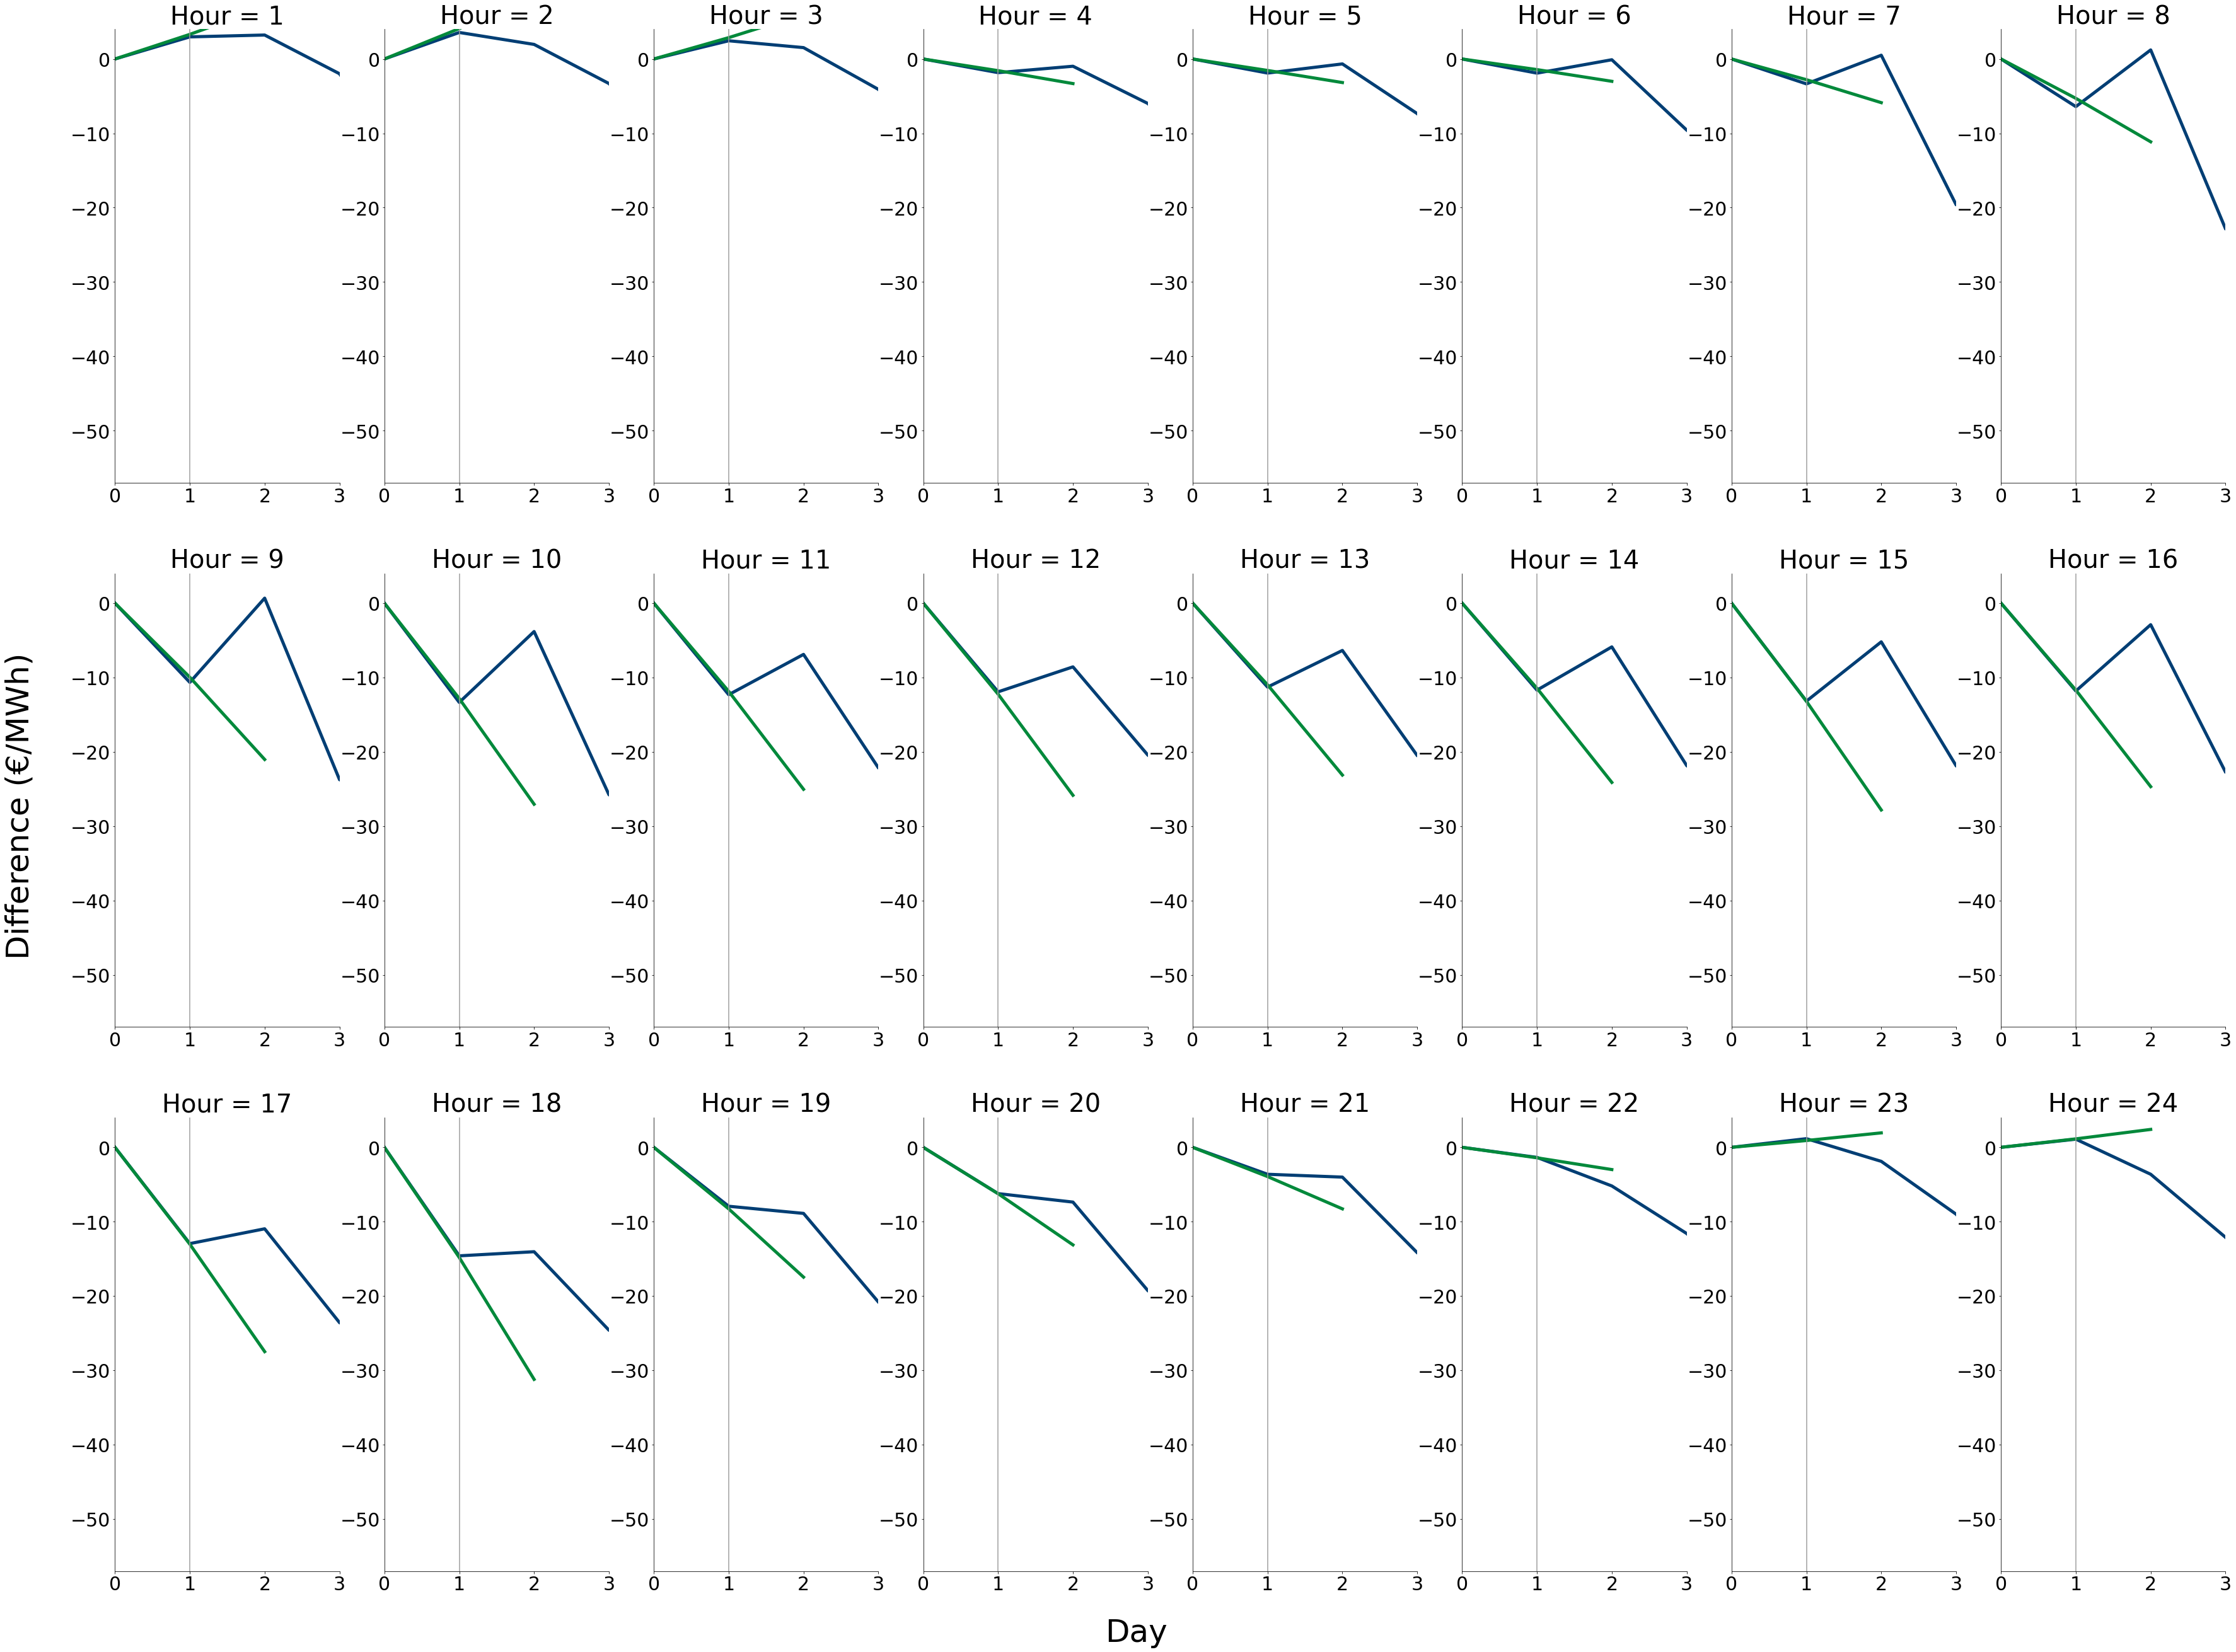

Mean absolute value error for test: 11.06




In [11]:
scenario_params.sim_periods = 3
pred_ext_drift_dict = train_neural_ode_external_drift(params=scenario_params,
                                                      signal_dimension=SignalDimension.Multivariate,
                                                      hidden_layer_neurons=96, 
                                                      train_df=hour_ts_diff_df)

### Add learnt external drift to simulated trajectories

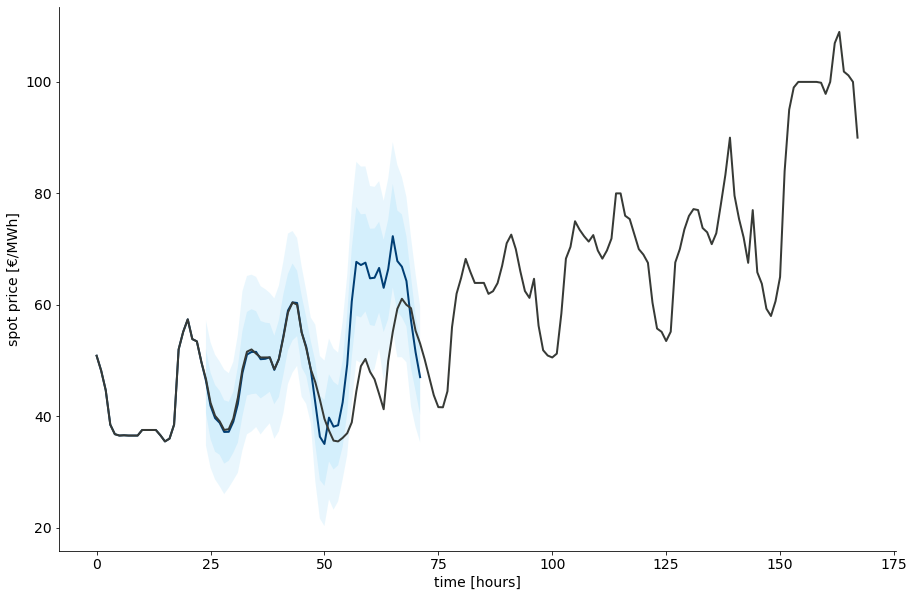

In [12]:
for k, pred_tensor in pred_ext_drift_dict.items():
    sim_ext_drift_df = apply_learnt_external_drift_to_sim(external_drift_tensor=pred_tensor, sim_df=sim_df)

    sim_dict = {"sim_df": sim_ext_drift_df, "actual_df": x_df_kde}
    plot_simulation(sim_dict=sim_dict)

### Train 24 simple neural ODEs to learn external drift

Training time step 1 - Iteration: 0000 | Total loss 4.964144 | Time: 0.02 mins


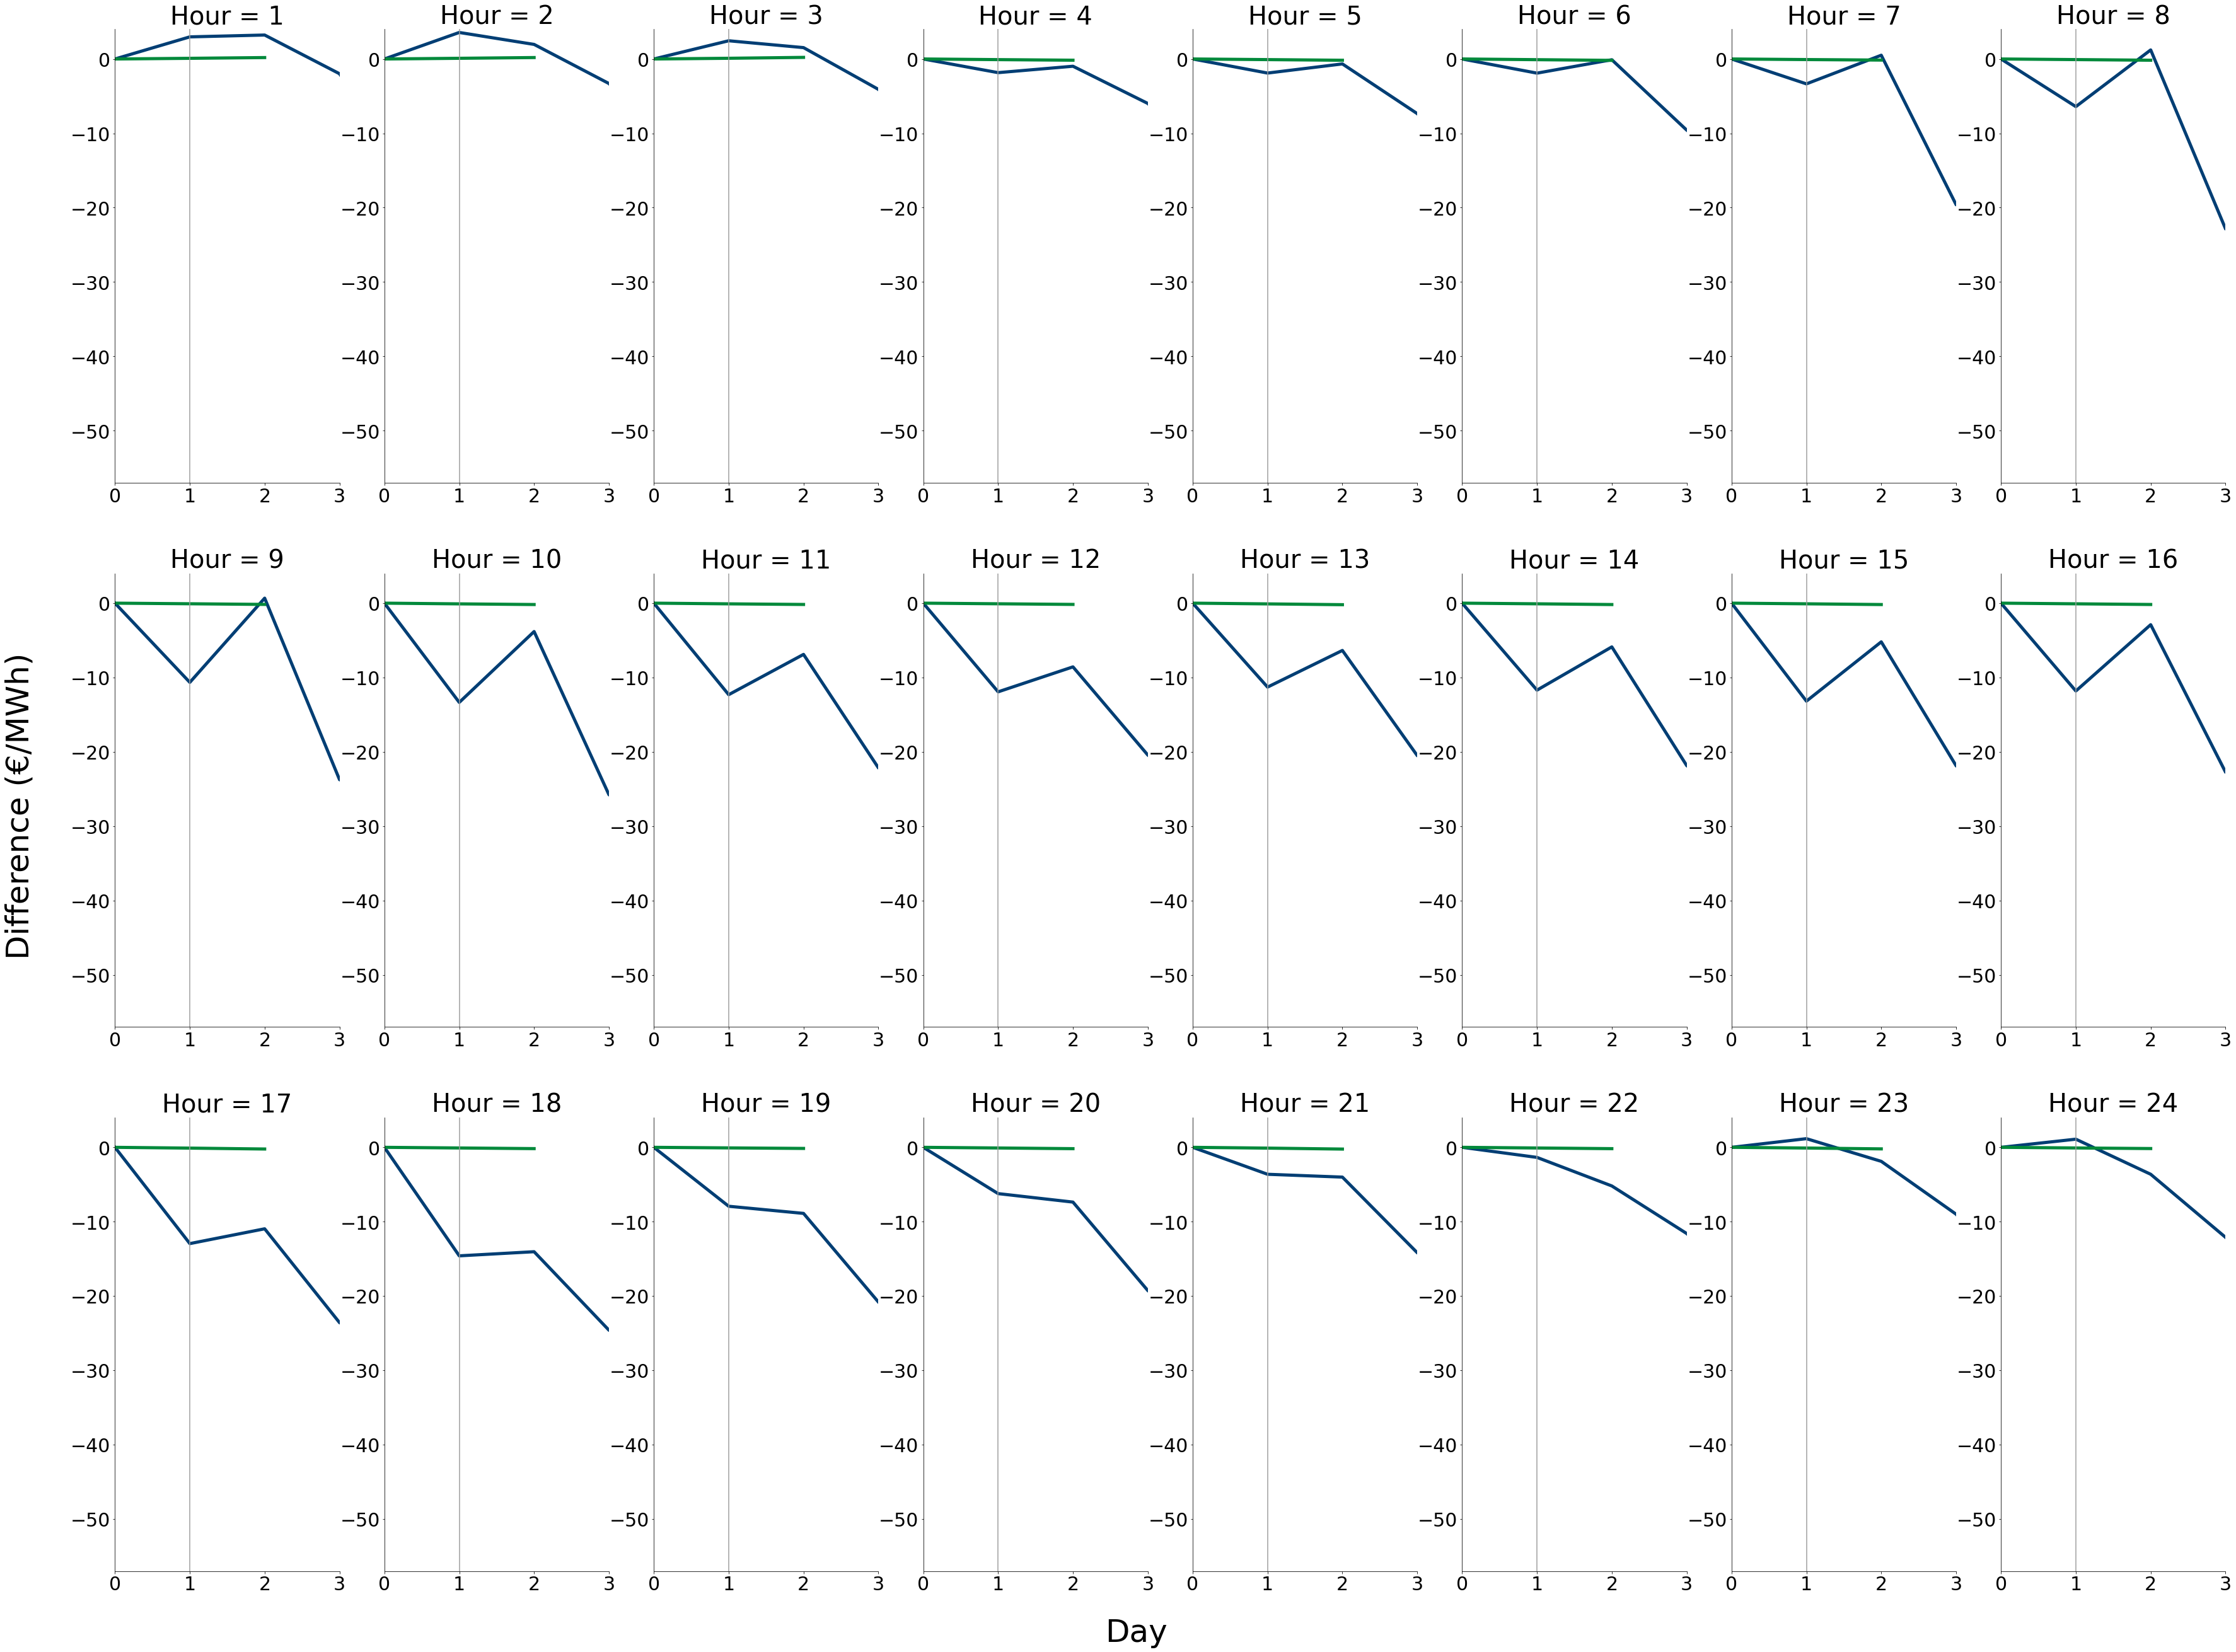

Mean absolute value error for test: 4.30


Training time step 1 - Iteration: 0250 | Total loss 3.791079 | Time: 0.53 mins
Training time step 1 - Iteration: 0500 | Total loss 3.778728 | Time: 1.01 mins
Training time step 1 - Iteration: 0750 | Total loss 3.749419 | Time: 1.49 mins
Training time step 1 - Iteration: 1000 | Total loss 3.796529 | Time: 1.99 mins


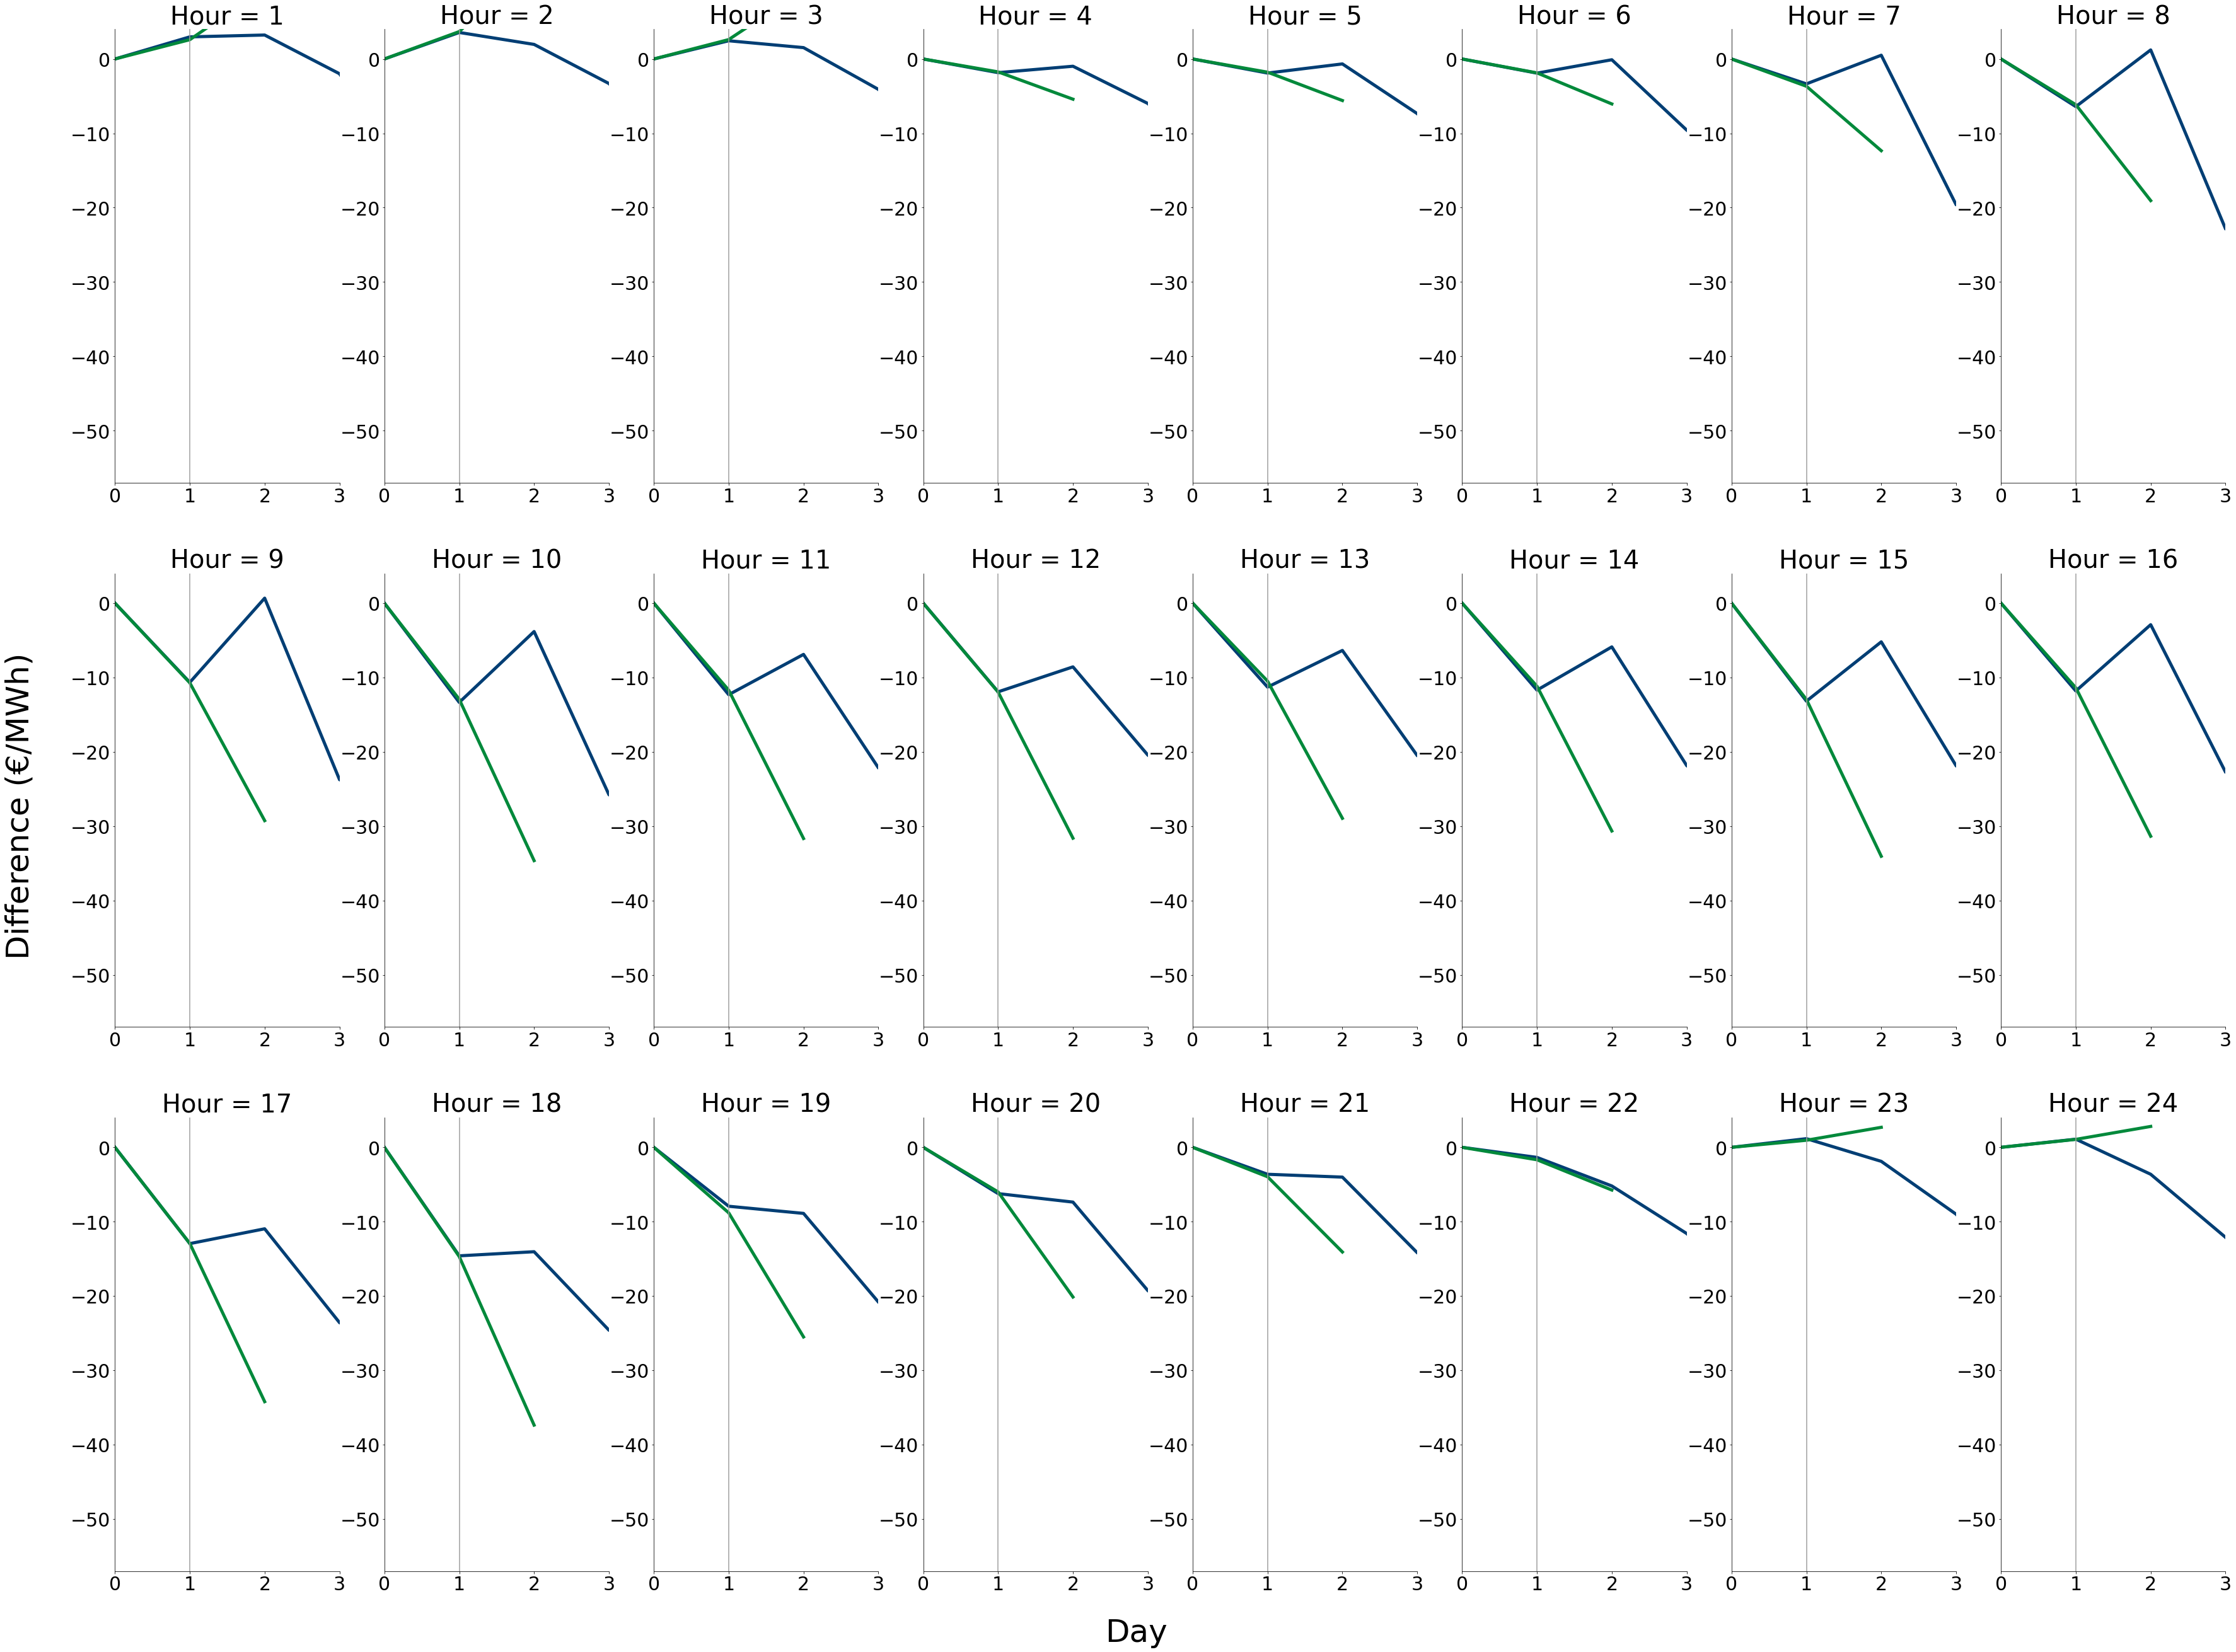

Mean absolute value error for test: 16.02


Training time step 1 - Iteration: 1250 | Total loss 3.786613 | Time: 2.51 mins
Training time step 1 - Iteration: 1500 | Total loss 3.770791 | Time: 3.01 mins
Training time step 1 - Iteration: 1750 | Total loss 3.756122 | Time: 3.50 mins
Training time step 1 - Iteration: 2000 | Total loss 3.807750 | Time: 3.99 mins


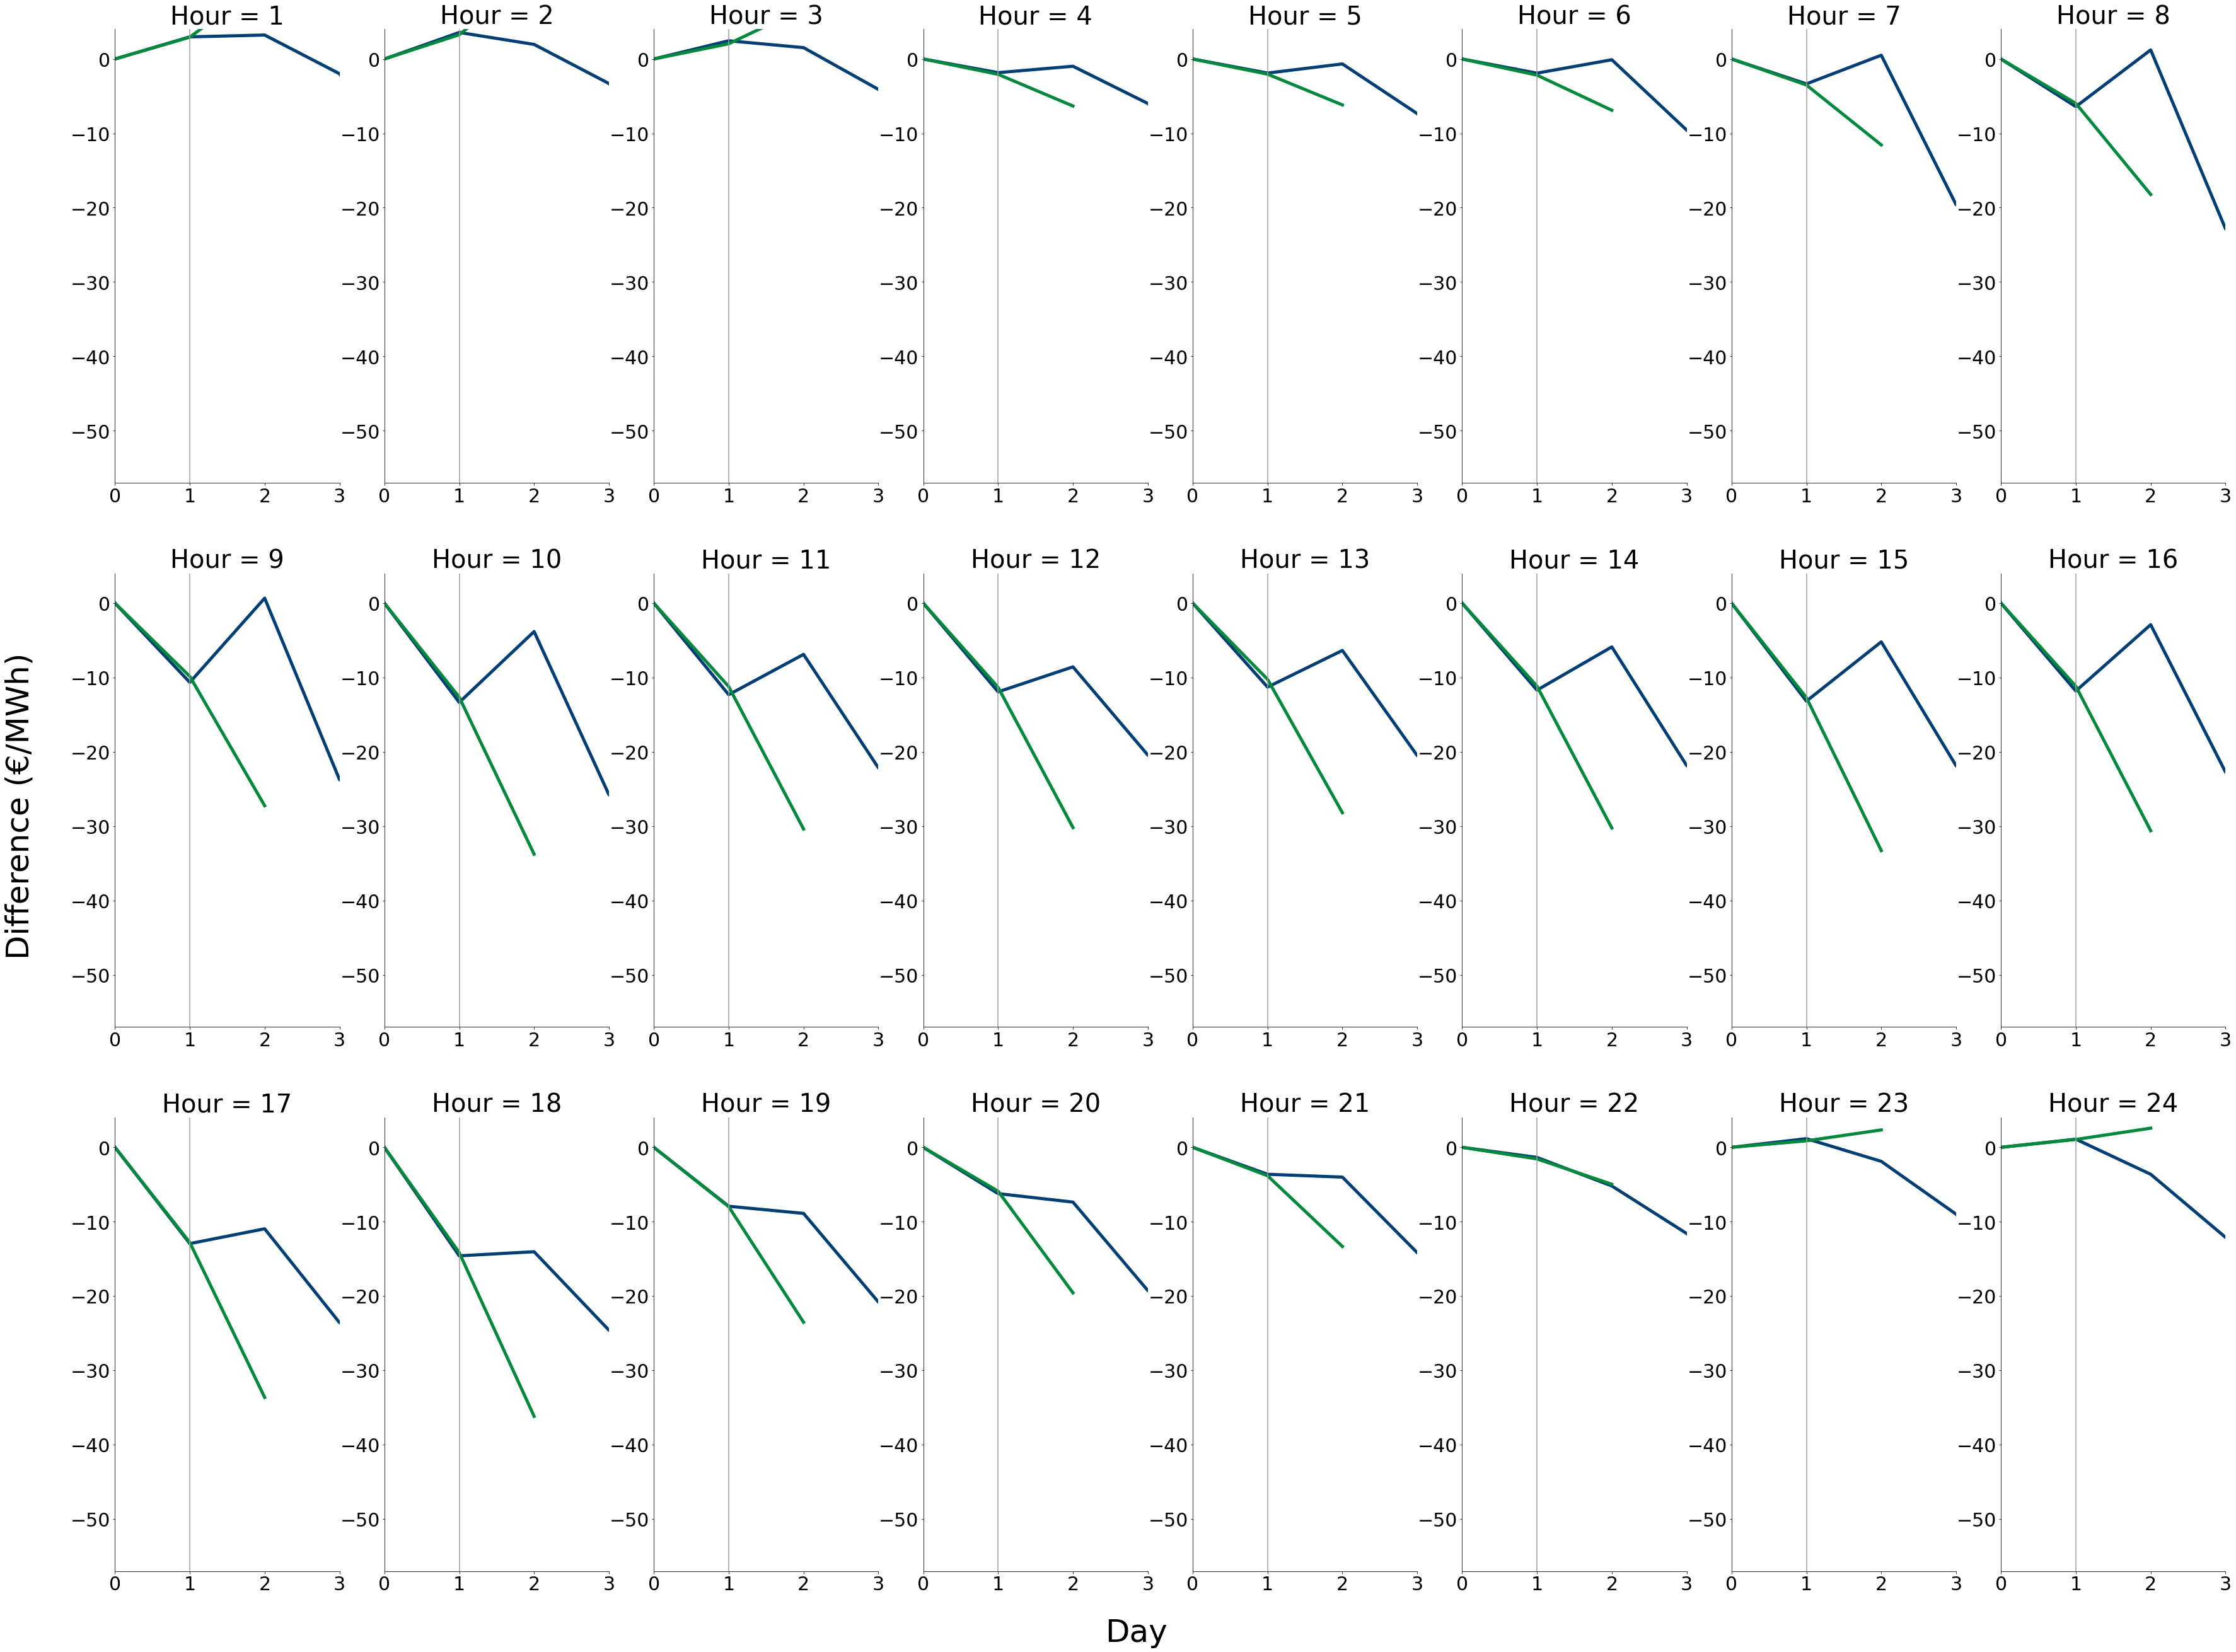

Mean absolute value error for test: 15.32




In [13]:
scenario_params.sim_periods = 3
pred_ext_drift_dict = train_univariate_neural_ode_external_drift(params=scenario_params,
                                           hidden_layer_neurons=24*4,
                                           learning_rate=1e-3,
                                           train_df=hour_ts_diff_df)

Training time step 1 - Iteration: 0000 | Total loss 5.246588 | Time: 0.00 mins


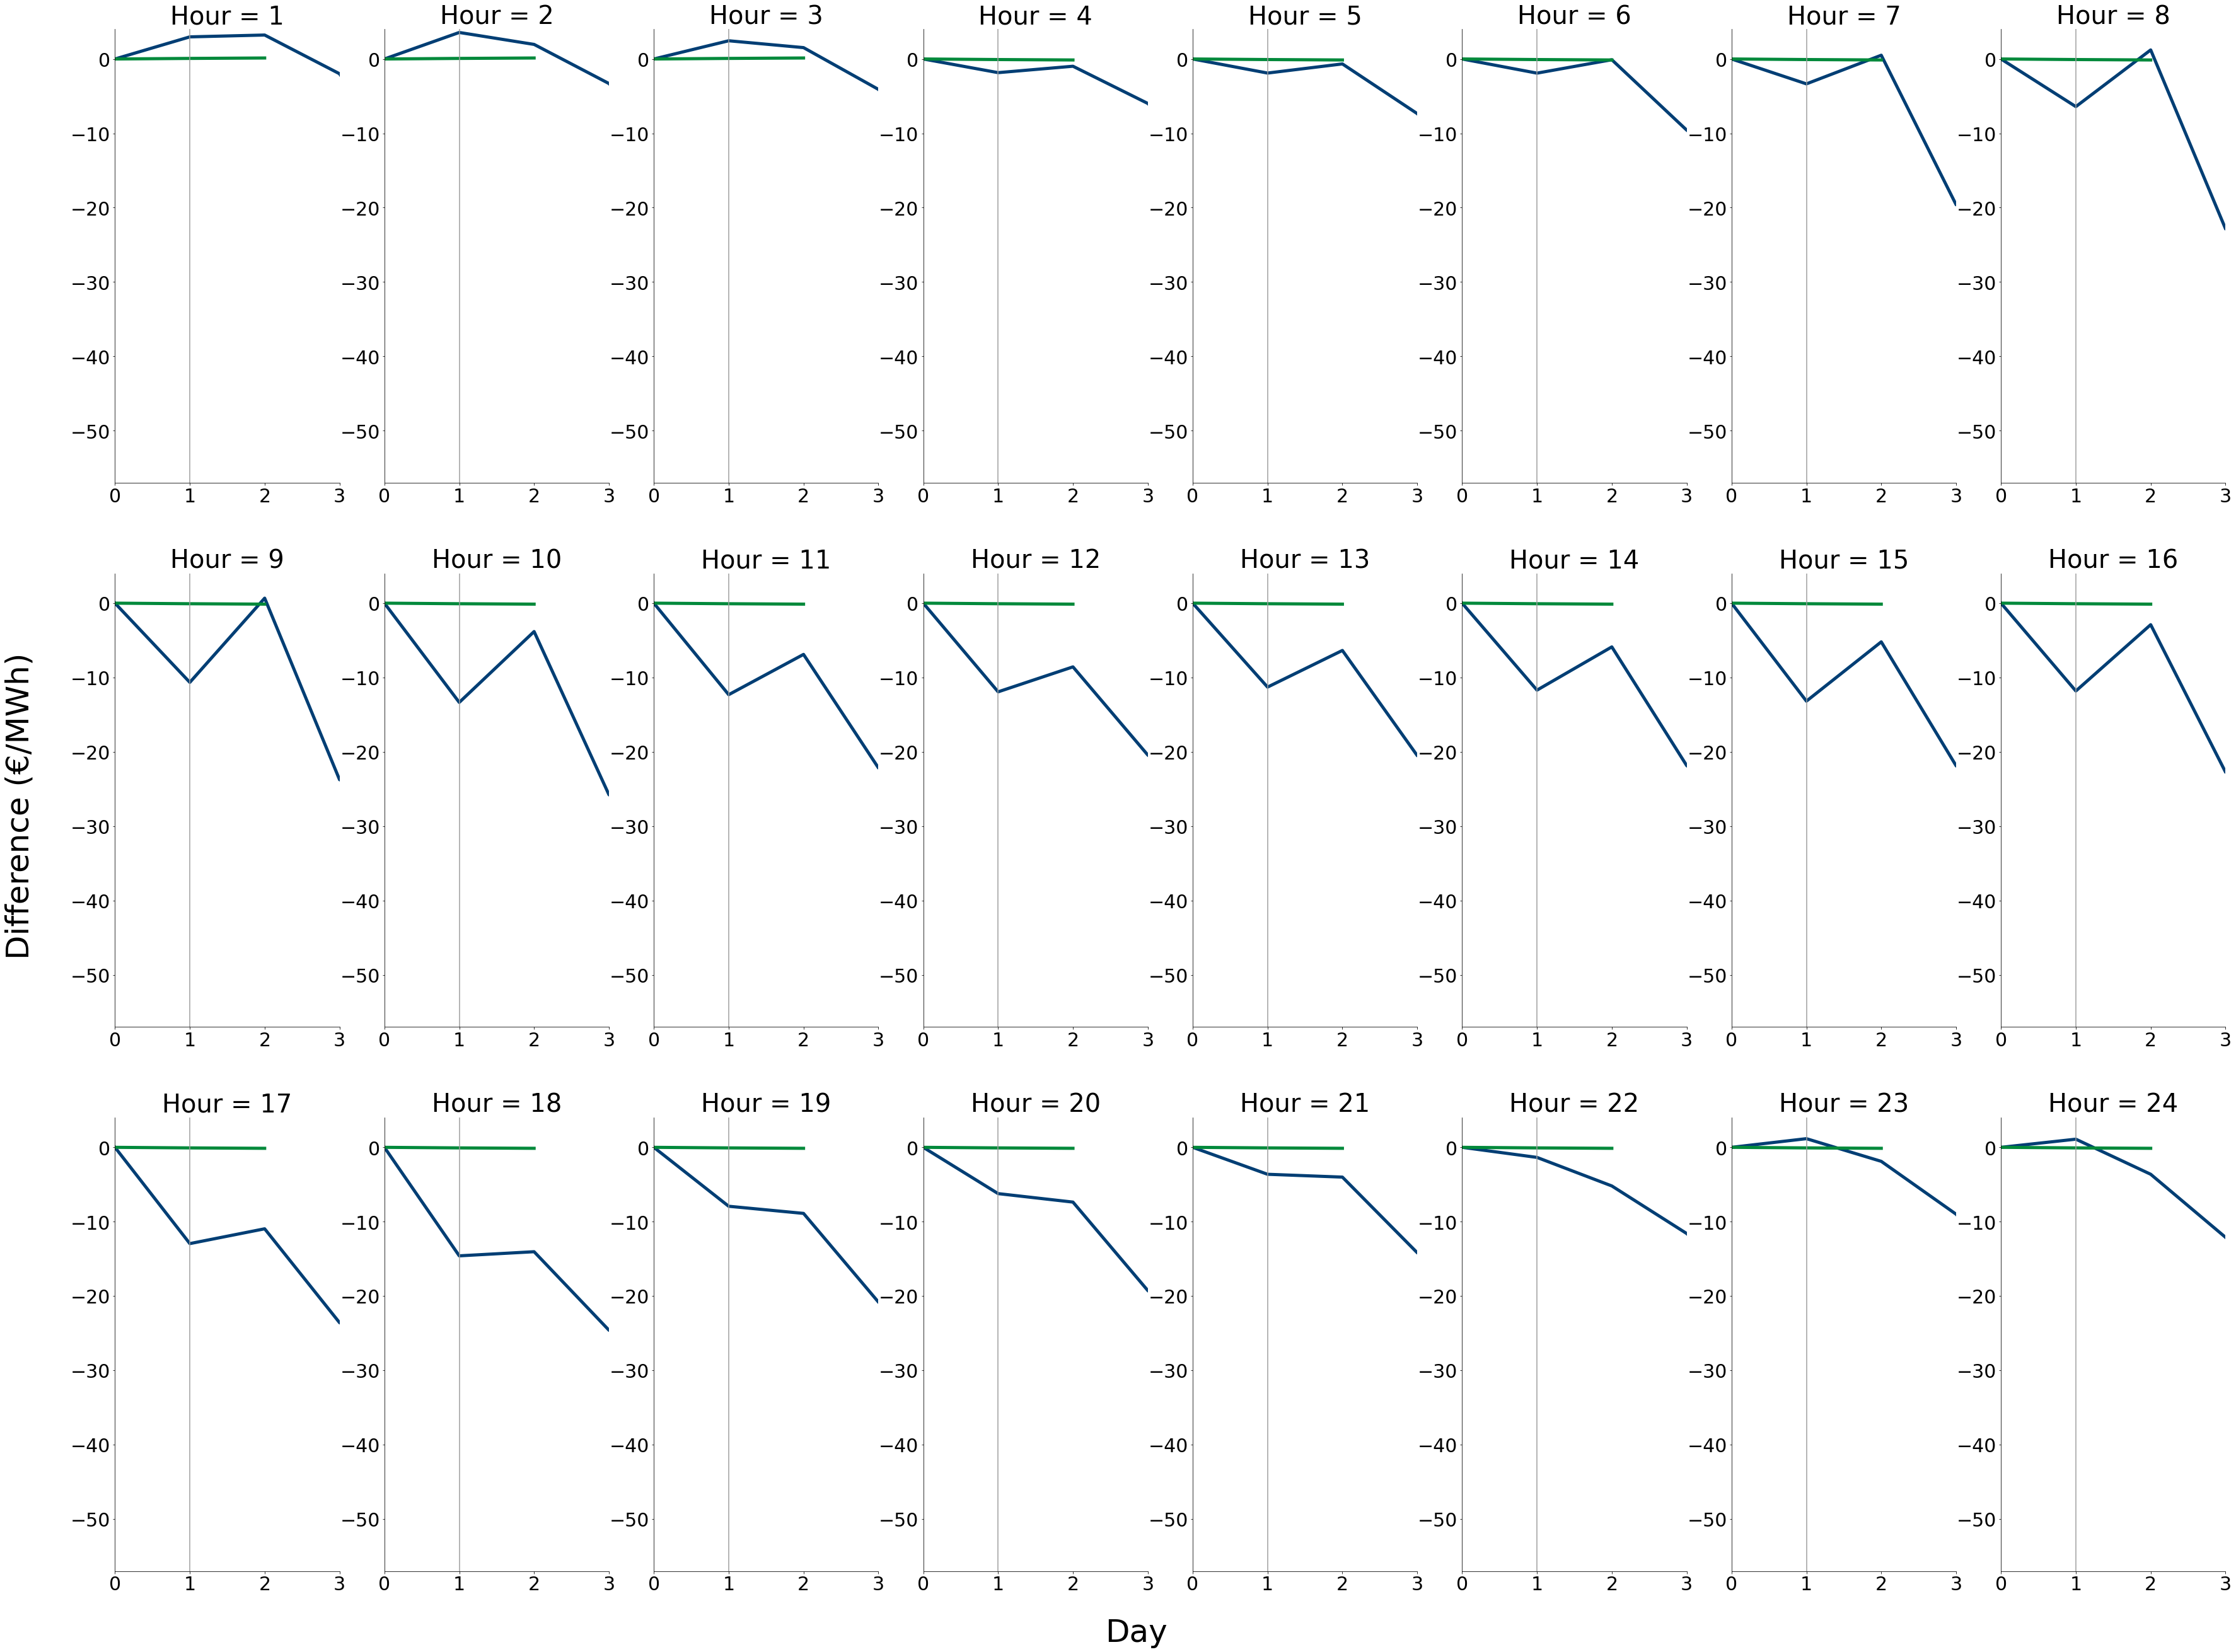

Mean absolute value error for test: 4.34


Training time step 1 - Iteration: 0250 | Total loss 3.807063 | Time: 0.48 mins
Training time step 1 - Iteration: 0500 | Total loss 3.789574 | Time: 0.96 mins
Training time step 1 - Iteration: 0750 | Total loss 3.799279 | Time: 1.43 mins
Training time step 1 - Iteration: 1000 | Total loss 3.783278 | Time: 1.89 mins


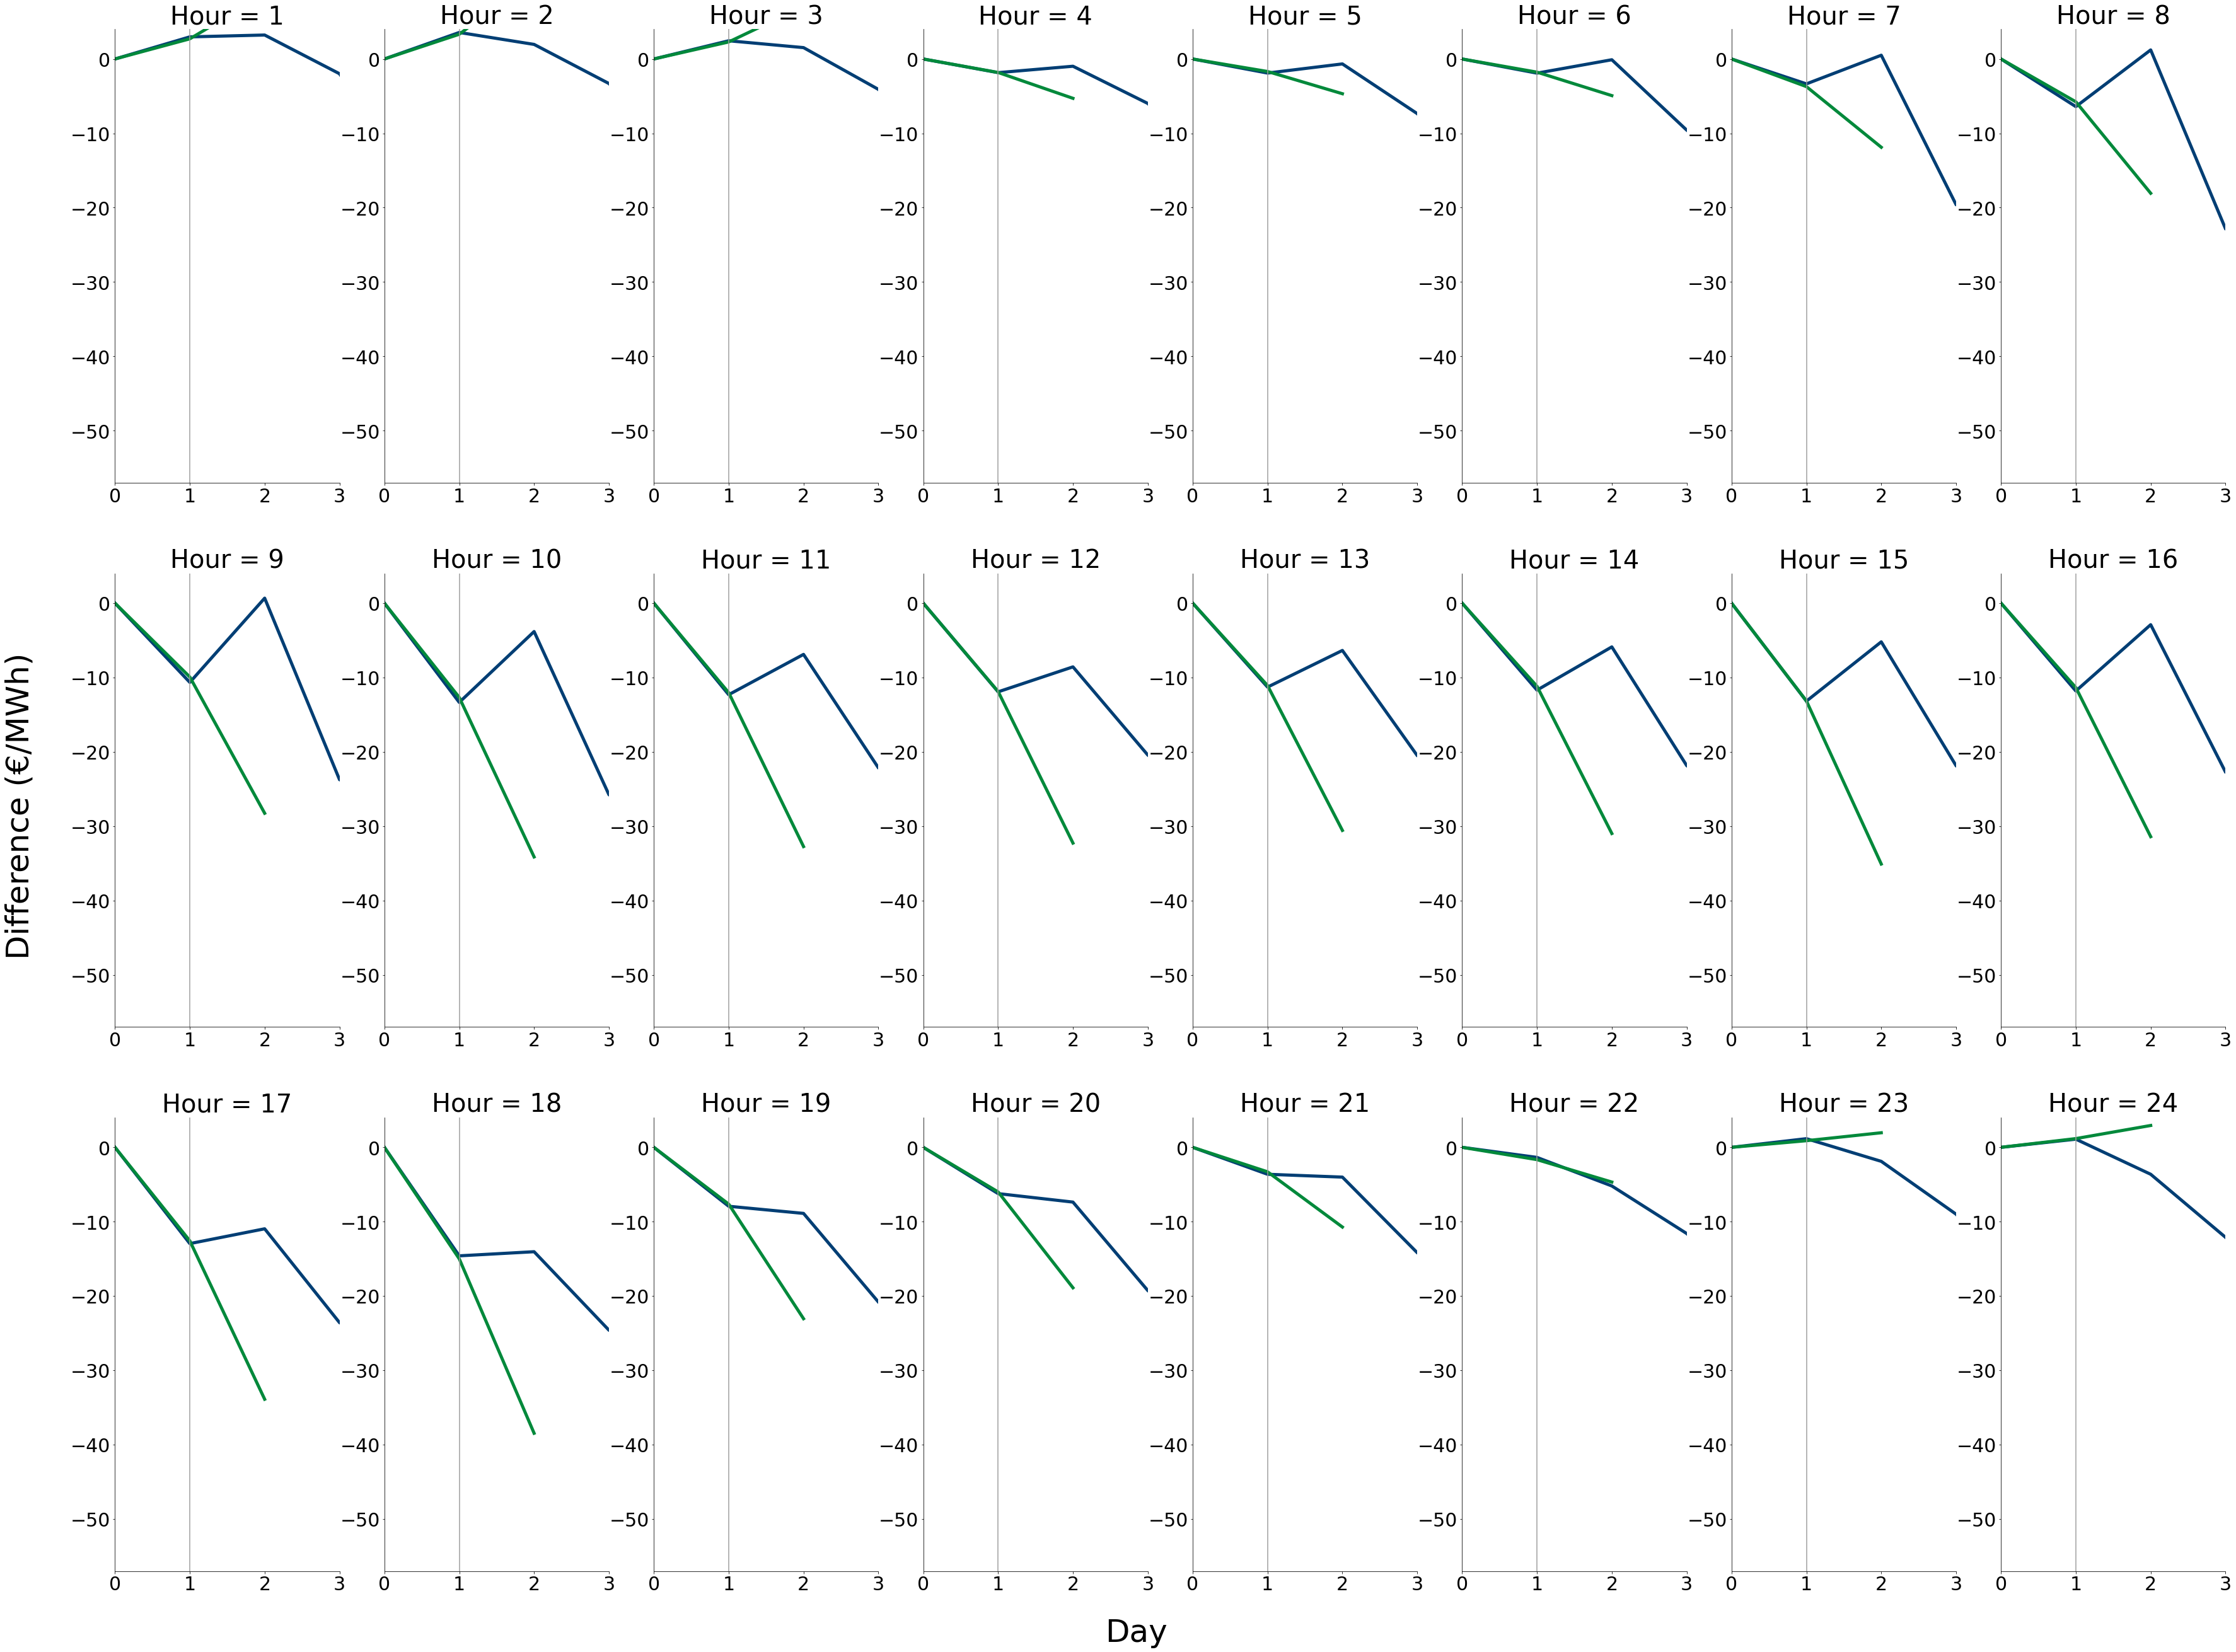

Mean absolute value error for test: 15.50


Training time step 1 - Iteration: 1250 | Total loss 3.792982 | Time: 2.40 mins
Training time step 1 - Iteration: 1500 | Total loss 3.794387 | Time: 2.89 mins
Training time step 1 - Iteration: 1750 | Total loss 3.785320 | Time: 3.37 mins
Training time step 1 - Iteration: 2000 | Total loss 3.812537 | Time: 3.85 mins


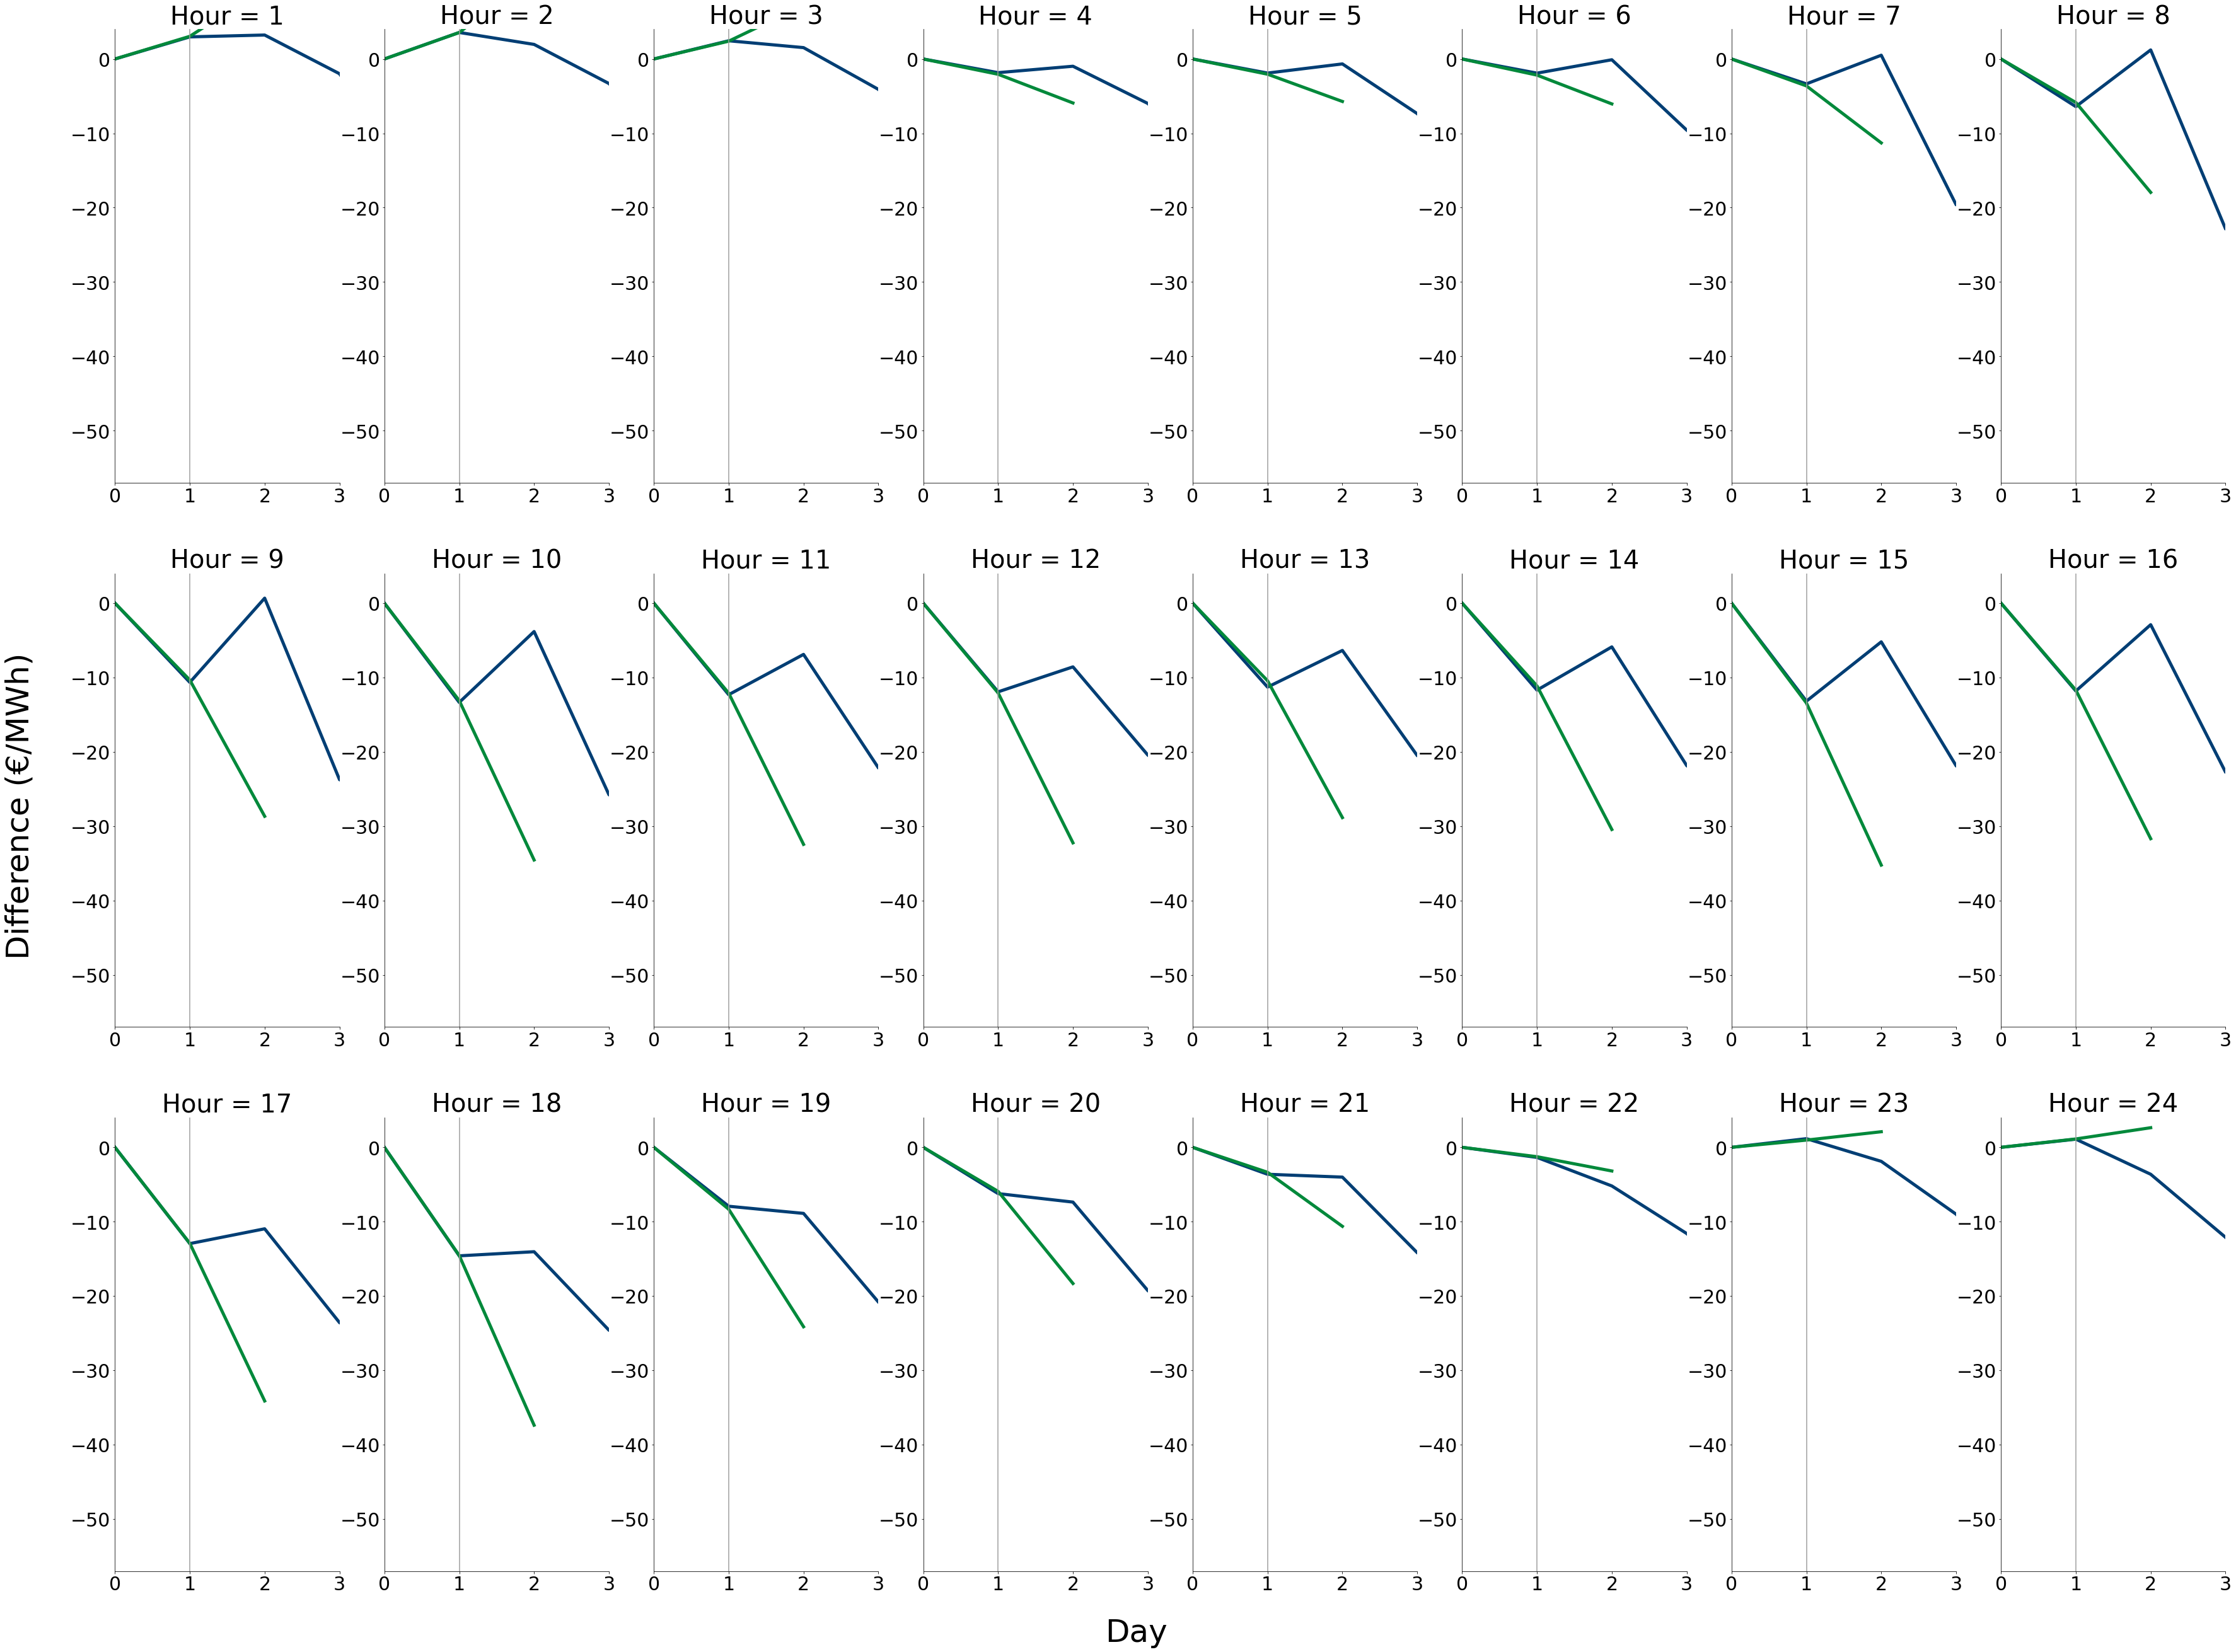

Mean absolute value error for test: 15.62




In [14]:
scenario_params.sim_periods = 3
pred_ext_drift_dict = train_neural_ode_external_drift(params=scenario_params,
                                                      signal_dimension=SignalDimension.Univariate,
                                                      hidden_layer_neurons=96, 
                                                      train_df=hour_ts_diff_df)

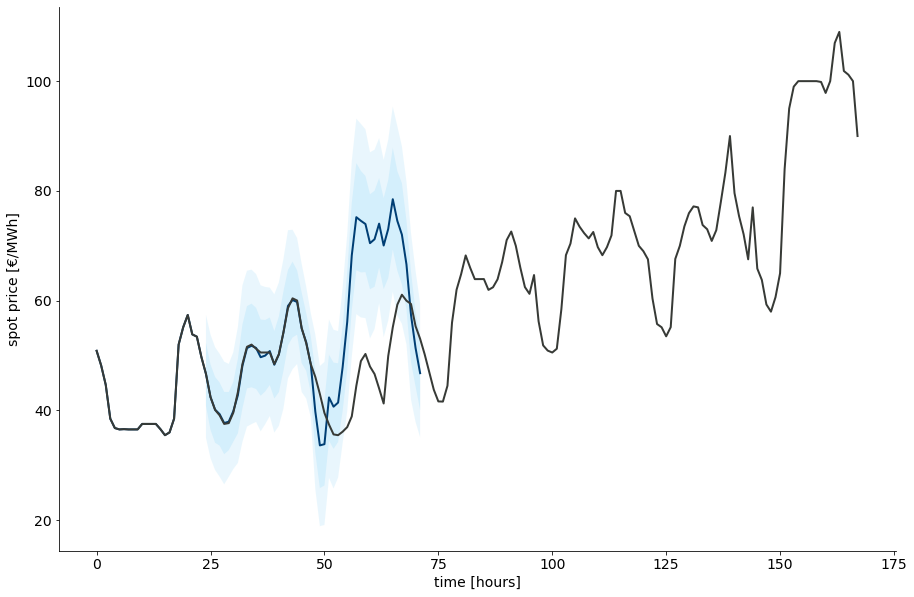

In [15]:
for k, pred_tensor in pred_ext_drift_dict.items():
    sim_ext_drift_df = apply_learnt_external_drift_to_sim(external_drift_tensor=pred_tensor, sim_df=sim_df)

    sim_dict = {"sim_df": sim_ext_drift_df, "actual_df": x_df_kde}
    plot_simulation(sim_dict=sim_dict)

Ideas to explore:
 - Try more elaborated neural network architecture
 - Expand test time range
 - Train 1 latent neural ODE of 24 input dimensions
 - Train 24 latent neural ODEs of 1 input dimension
 - Classic ML (splines, boosting, gaussian mixture model) regressor inside a numerical integrator